**How to identify position players on a given date?**

**Problem:**
<br>
In daily fantasy baseball, a participant sets up their team against another player of their league. Some position players are stars and should play nearly all the time, but often a position is shared between other players on your roster. How do you choose which platooning player to start (especially if there is a limited sample size for the batter facing that pitcher)?

**Strategy:**
<br>
- Focus on features of the batter (e.g. historical batting average) and pitcher (e.g. historical ERA, WHIP) to predict whether the batter would output a hit (or HR, single, double, etc.) in a given batter-pitcher at-bat matchup.

- If you choose a given date (e.g. May 9), you know the starting pitcher a batter would face. Use data to build a model taht predicts how well a batter would do against the pitcher as a guide for a decision. (Lower priority: If the matchup for a particular batter-pitcher is small, find similar players to serve as a guide. Similar players can be found by using Erdos score.)

- How do I know if my strategy is improved over other models? Look at which player one would choose from a simple player ranking.

- Validation: Historical data

This notebook was created within my "insight" virtual environment.

**Inputs and outputs**

*Version 1:*
- Input: Two players under consideration for one position and a date of interest (2019 season for historical validation).
- Output: Player recommendation for that position with a predicted score.

*Version 2:*
- Input: A participant's player roster (e.g. 20 players)
- Output: A recommended lineup.

Order of features of product to incorporate: (still to be determined)

0.  Try a simple model where each at-bat batter-pitcher matchup is simply its own row and selected features are done. (DONE)
1.	Roster’s “basic” baseball statistics from 2018 season? Or 50 games (including previous season) - (minimum viable product level) (DONE)
2.	Specific matchup against that pitcher - “basic” baseball statistics
3.	Roster’s statcast statistics from last 50 games (including previous season) (DONE)
4.	Limit to more recent performance (last 100 at-bats games - dataframe for model does 200 rows)
5.	Weather, park effects, team defense, night/day, lineup order
6. Use batted ball characteristics as a feature of player and pitcher (launch angle average, launch speed average)
7.	Use of player similarity (lower priority)

Similar idea
https://community.fangraphs.com/the-outcome-machine-predicting-at-bats-before-they-happen/

https://blogs.fangraphs.com/bettermatch-up-data-forecasting-strikeout-rate/

EDA, do HR over time and by date for each player


**Focus on predicting just the proportion of it happening using historical batter pitcher data**

- use aggregated stats
- get CI for each?
- linear regression with batter and pitcher as a variable 
- do for HR, etc 

**Product pitch**

I'm creating a fantasy baseball application that suggests players on a given day. Fantasy baseball has over 11 million participants with the winners of leagues collecting entry fees and host platforms receiving a commission. The projected market for fantasy baseball in 2020 is over 8 billion dollars. A participant's success depends in part on daily player selection. For player selection, participants must rely on their own research or use a site's recommendation, which uses black-box algorithms behind pay walls. I'm developing an alternative algorithm to assist in player selection to save participants time and expose the important features in player performance prediction.

# Ideas

- Will hit happen based on pitch count
- Use last 100 at-bats from the date of interest.
- Use Bayesian?
- EDA  - plot someone's hits over game-dates as a time series
- Look at the player's last 100 hits 

Other:
- Use all info for at-bat and then do backwards selection.

**Motivation: Learning analytics requries some skills I can develop here**

# Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from termcolor import colored

# Web/database stuff
import urllib.request
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup

# Multiprocessing/threading
import multiprocess
import threading
from threading import Thread

In [2]:
# Web/database stuff
# import urllib.request
# import xml.etree.ElementTree as ET
# from bs4 import BeautifulSoup
import sqlalchemy
import sqlalchemy_utils
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

# Multiprocessing/threading
import multiprocess
import threading   # included in base

In [707]:
# Stats
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols

<IPython.core.display.Javascript object>

In [4]:
# ML
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [5]:
# Check versioning
print('numpy: ', np.__version__)
print('pandas: ', pd.__version__)
print('matplotlib: ', matplotlib.__version__)
print('seaborn: ', sns.__version__)
print('sklearn: ', sklearn.__version__)

print('psycopg2: ', psycopg2.__version__)
print('sqlalchemy: ', sqlalchemy.__version__)
print('sqlalchemy_utils: ', sqlalchemy_utils.__version__)
print('multiprocess: ', multiprocess.__version__)

numpy:  1.17.4
pandas:  0.25.3
matplotlib:  3.1.1
seaborn:  0.9.0
sklearn:  0.22
psycopg2:  2.8.4 (dt dec pq3 ext lo64)
sqlalchemy:  1.3.11
sqlalchemy_utils:  0.36.1
multiprocess:  0.70.9


In [6]:
# Code formatting with Jupyter black
%load_ext nb_black

<IPython.core.display.Javascript object>

In [7]:
from pybaseball import pitching_stats
from pybaseball import batting_stats
from pybaseball import statcast_pitcher
from pybaseball import playerid_lookup
from pybaseball import statcast
from pybaseball import playerid_reverse_lookup

<IPython.core.display.Javascript object>

# Database info

In [8]:
# Define a database name
# Set your postgres username
dbname = "baseball"
username = "lacar"  # change this to your username

<IPython.core.display.Javascript object>

In [9]:
## 'engine' is a connection to a database
## Here, we're using postgres, but sqlalchemy can connect to other things too.
engine = create_engine("postgres://%s@localhost/%s" % (username, dbname))
print(engine.url)

postgres://lacar@localhost/baseball


<IPython.core.display.Javascript object>

**Statcast data to database**
<br>
(done already, see previous versions of notebooks)

In [140]:
# Get more data, 2015 and 2016 seasons when launch angle was available

# 2015 regular season
# df_statcast_15 = statcast('2015-04-05', '2015-10-04')


This is a large query, it may take a moment to complete
Completed sub-query from 2015-04-05 to 2015-04-10
Completed sub-query from 2015-04-11 to 2015-04-16
Completed sub-query from 2015-04-17 to 2015-04-22
Completed sub-query from 2015-04-23 to 2015-04-28
Completed sub-query from 2015-04-29 to 2015-05-04
Completed sub-query from 2015-05-05 to 2015-05-10
Completed sub-query from 2015-05-11 to 2015-05-16
Completed sub-query from 2015-05-17 to 2015-05-22
Completed sub-query from 2015-05-23 to 2015-05-28
Completed sub-query from 2015-05-29 to 2015-06-03
Completed sub-query from 2015-06-04 to 2015-06-09
Completed sub-query from 2015-06-10 to 2015-06-15
Completed sub-query from 2015-06-16 to 2015-06-21
Completed sub-query from 2015-06-22 to 2015-06-27
Completed sub-query from 2015-06-28 to 2015-07-03
Completed sub-query from 2015-07-04 to 2015-07-09
Completed sub-query from 2015-07-10 to 2015-07-15
Completed sub-query from 2015-07-16 to 2015-07-21
Completed sub-query from 2015-07-22 to 2015-

<IPython.core.display.Javascript object>

In [141]:
# df_statcast_15.tail()

,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
702297,17574,CU,2015-04-05,75.9,NaN,NaN,Jon Lester,572761.0,452657.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
702298,17575,FF,2015-04-05,91.6,NaN,NaN,Jon Lester,572761.0,452657.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
702299,17576,FF,2015-04-05,94.8,2.6267,5.2936,Jon Lester,572761.0,452657.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
702300,17577,FF,2015-04-05,93.4,2.5694,5.6476,Jon Lester,572761.0,452657.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
702301,17578,FF,2015-04-05,93.6,2.5520,5.5293,Jon Lester,572761.0,452657.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


<IPython.core.display.Javascript object>

In [142]:
# Send to database
#df_statcast_15.to_sql("statcast_15", engine)

<IPython.core.display.Javascript object>

In [ ]:

# 2016 regular season (do this in other notebook)
# df_statcast_16 = statcast('2016-04-03', '2016-10-02')



Filter out Astros data?

In [10]:
## create a database (if it doesn't exist)
# if not database_exists(engine.url):
#     create_database(engine.url)
# print(database_exists(engine.url))

<IPython.core.display.Javascript object>

In [11]:
# This is done, but note it's out of order

# date_list = [
#     ("2019-03-20", "2019-09-29"),
#     ("2018-03-29", "2018-10-01"),
#     ("2017-04-02", "2017-10-01"),
# ]

# Above gave **2,174,906** pitch-by-pitch results in the database

#     ("2016-04-03", "2016-10-02"),   # didn't get
#     ("2015-04-05", "2015-10-04"),   # didn't get


# for i, date_pair in enumerate(date_list):
#     if i < 1:
#         df_sc = statcast(date_pair[0], date_pair[1])
#         df_sc.to_sql("statcast", engine, if_exists="replace")
#         print(date_pair, "replace mode")
#     else:
#         df_sc = statcast(date_pair[0], date_pair[1])
#         df_sc.to_sql("statcast", engine, if_exists="append")
#         print(date_pair, "append mode")

<IPython.core.display.Javascript object>

In [10]:
# Working with PostgreSQL in Python
# Connect to make queries using psycopg2
con = None
con = psycopg2.connect(database=dbname, user=username)

<IPython.core.display.Javascript object>

See other notebook for more info



In [11]:
# Get player id
sql_query = """
SELECT * FROM player_id;
"""

df_player_id = pd.read_sql_query(sql_query, con)

<IPython.core.display.Javascript object>

In [12]:
# Batting stats

sql_query = """
SELECT * FROM batting_stats18_wpid;
"""

df_batting_stats_wpid = pd.read_sql_query(sql_query, con)

<IPython.core.display.Javascript object>

In [13]:
df_batting_stats_wpid.shape

(955, 300)

<IPython.core.display.Javascript object>

In [14]:
df_batting_stats_wpid.head()

,index,index_x,Season,Name,Team,Age,G,AB,PA,H,...,first_name,index_y,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,0,63,2018.0,Mookie Betts,Red Sox,25.0,136.0,520.0,614.0,180.0,...,mookie,166,betts,mookie,605141,bettm001,bettsmo01,13611,2014.0,2019.0
1,1,67,2018.0,Mike Trout,Angels,26.0,140.0,471.0,608.0,147.0,...,mike,1789,trout,mike,545361,troum001,troutmi01,10155,2011.0,2019.0
2,2,153,2018.0,Jose Ramirez,Indians,25.0,157.0,578.0,698.0,156.0,...,jose,1417,ramirez,jose,542432,ramij004,ramirjo02,10171,2014.0,2018.0
3,68,38,2018.0,Ryder Jones,Giants,24.0,5.0,8.0,8.0,3.0,...,ryder,903,jones,ryder,624507,joner005,jonesry01,15982,2017.0,2018.0
4,3,153,2018.0,Jose Ramirez,Indians,25.0,157.0,578.0,698.0,156.0,...,jose,1418,ramirez,jose,608070,ramij003,ramirjo01,13510,2013.0,2019.0


<IPython.core.display.Javascript object>

In [15]:
# Pitching stats

sql_query = """
SELECT * FROM pitching_stats_wpid;
"""

df_pitching_stats_wpid = pd.read_sql_query(sql_query, con)
# Limit to 2018, like with baseball stats
df_pitching_stats_wpid = df_pitching_stats_wpid[
    df_pitching_stats_wpid["Season"] == 2018
].copy()

<IPython.core.display.Javascript object>

In [16]:
df_pitching_stats_wpid.shape

(789, 310)

<IPython.core.display.Javascript object>

In [17]:
df_pitching_stats_wpid.head()

,index,Season,Name,Team,Age,W,L,ERA,WAR,G,...,first_name,last_name,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,0,2018.0,Jacob deGrom,Mets,30.0,10.0,9.0,1.70,9.0,32.0,...,jacob,degrom,degrom,jacob,594798.0,degrj001,degroja01,10954.0,2014.0,2019.0
2,2,2018.0,Max Scherzer,Nationals,33.0,18.0,7.0,2.53,7.5,33.0,...,max,scherzer,scherzer,max,453286.0,schem001,scherma01,3137.0,2008.0,2019.0
4,1587,2018.0,Scott Kingery,Phillies,24.0,0.0,0.0,13.50,0.0,1.0,...,scott,kingery,kingery,scott,664068.0,kings001,kingesc01,17975.0,2018.0,2019.0
8,7,2018.0,Justin Verlander,Astros,35.0,16.0,9.0,2.52,6.6,34.0,...,justin,verlander,verlander,justin,434378.0,verlj001,verlaju01,8700.0,2005.0,2019.0
12,11,2018.0,Chris Sale,Red Sox,29.0,12.0,4.0,2.11,6.2,27.0,...,chris,sale,sale,chris,519242.0,salec001,salech01,10603.0,2010.0,2019.0


<IPython.core.display.Javascript object>

# Notes

## Contingencies

1. What if player has day off? or no game is scheduled?
2. What if player or pitcher doesn't have minimum nback at-bats?
3. What if player doesn't have minimum nback at-bats against same or opposite handedness?

**Quora answer on number of plate appearances**
https://www.quora.com/How-many-at-bats-does-the-average-MLB-player-go-through-per-year

One direction to go with is how many PA wpild a player accumulate if theu were to play every day, and not rest. That would be around 725. Though that total is not really an average as few players exceed such a total each year.

A second number would be how many plate appearances bases on normal rest during a season if a player never was injured, about 145-150 games for position players other then the catcher and 110 to 115 for catchers. Those totals would be around 650 and 450 respectively.

Yet another way to answer this would be the number of PA by all position players on a roster that were supposed to be starters, but may receive less playing time due to injury or a team developing, trading for or discovering a better player. That would probably be closer to 400.

You could also thing about all position players on a team including bench players, if we include them our total now is closer to 200-250.

Yet another way to look at this is to include all players on the roster including pitcher who may notbat intentionally. Include them and tour total is closer to 100-120.

## Other ideas


- Look at probabilities, instead of looking for 1 (done - not strong)
- Aggregate per game (potentially something there - not sure)
- Look at Ty France
- Add in pitcher info 
- See what pitches they're hitting, then see how that matches with pitchers 
- Remember that ultimately, we want to see that we're picking the right player - someone who has a higher probability overall will be better choice


**Motivation: Learning analytics requries some skills I can develop here**

## Questions to ask

- Am I inputting handedness correctly? How to input values if they're transformed in the model? (L -1.41421356, R 0.70710678)
- Add pitcher specific ID as a factor?


## Things to fix

- Standardize train-test before split (done)

# Data acquisition

## Get statcast data

In [18]:
def get_sc_event_data():
    sql_query = """
    (SELECT statcast.game_date, statcast.batter,
    statcast.pitcher, statcast.events,
    statcast.stand, statcast.p_throws,
    statcast.inning_topbot
    FROM statcast
    WHERE statcast.events IS NOT NULL);
    """

    print(sql_query)

    df_sc_events = pd.read_sql_query(sql_query, con)

    return df_sc_events

<IPython.core.display.Javascript object>

In [19]:
df_sc_events = get_sc_event_data()


    (SELECT statcast.game_date, statcast.batter,
    statcast.pitcher, statcast.events,
    statcast.stand, statcast.p_throws,
    statcast.inning_topbot
    FROM statcast
    WHERE statcast.events IS NOT NULL);
    


<IPython.core.display.Javascript object>

In [20]:
print(df_sc_events["game_date"].min(), df_sc_events["game_date"].max())

2017-04-02 00:00:00 2019-09-29 00:00:00


<IPython.core.display.Javascript object>

In [21]:
df_sc_events.head()

,game_date,batter,pitcher,events,stand,p_throws,inning_topbot
0,2017-04-03,425783.0,446372.0,strikeout,L,R,Bot
1,2017-04-03,488726.0,506433.0,field_out,L,R,Top
2,2017-04-03,596019.0,506433.0,grounded_into_double_play,L,R,Top
3,2017-04-03,467793.0,506433.0,walk,L,R,Top
4,2017-04-03,501659.0,506433.0,walk,L,R,Top


<IPython.core.display.Javascript object>

In [22]:
def get_sc_event_data_15():
    sql_query = """
    (SELECT statcast_15.game_date, statcast_15.batter,
    statcast_15.pitcher, statcast_15.events,
    statcast_15.stand, statcast_15.p_throws,
    statcast_15.inning_topbot
    FROM statcast_15
    WHERE statcast_15.events IS NOT NULL);
    """

    print(sql_query)

    df_sc_events = pd.read_sql_query(sql_query, con)

    return df_sc_events

<IPython.core.display.Javascript object>

In [23]:
df_sc_events_15 = get_sc_event_data_15()


    (SELECT statcast_15.game_date, statcast_15.batter,
    statcast_15.pitcher, statcast_15.events,
    statcast_15.stand, statcast_15.p_throws,
    statcast_15.inning_topbot
    FROM statcast_15
    WHERE statcast_15.events IS NOT NULL);
    


<IPython.core.display.Javascript object>

In [24]:
print(df_sc_events_15["game_date"].min(), df_sc_events_15["game_date"].max())

2015-04-05 00:00:00 2015-10-04 00:00:00


<IPython.core.display.Javascript object>

In [25]:
df_sc_events_15.head()

,game_date,batter,pitcher,events,stand,p_throws,inning_topbot
0,2015-10-04,150029.0,544727.0,field_out,R,R,Top
1,2015-10-04,547180.0,544727.0,double,L,R,Top
2,2015-10-04,607208.0,544727.0,strikeout,R,R,Top
3,2015-10-04,543685.0,544727.0,field_out,R,R,Top
4,2015-10-04,502517.0,595014.0,grounded_into_double_play,L,R,Bot


<IPython.core.display.Javascript object>

In [26]:
def get_sc_event_data_16():
    sql_query = """
    (SELECT statcast_16.game_date, statcast_16.batter,
    statcast_16.pitcher, statcast_16.events,
    statcast_16.stand, statcast_16.p_throws,
    statcast_16.inning_topbot
    FROM statcast_16
    WHERE statcast_16.events IS NOT NULL);
    """

    print(sql_query)

    df_sc_events = pd.read_sql_query(sql_query, con)

    return df_sc_events

<IPython.core.display.Javascript object>

In [27]:
df_sc_events_16 = get_sc_event_data_16()


    (SELECT statcast_16.game_date, statcast_16.batter,
    statcast_16.pitcher, statcast_16.events,
    statcast_16.stand, statcast_16.p_throws,
    statcast_16.inning_topbot
    FROM statcast_16
    WHERE statcast_16.events IS NOT NULL);
    


<IPython.core.display.Javascript object>

In [28]:
print(df_sc_events_16["game_date"].min(), df_sc_events_16["game_date"].max())

2016-04-03 00:00:00 2016-09-30 00:00:00


<IPython.core.display.Javascript object>

In [29]:
df_sc_events_16.head()

,game_date,batter,pitcher,events,stand,p_throws,inning_topbot
0,2016-09-30,425900.0,518886.0,strikeout,L,R,Top
1,2016-09-30,453064.0,518886.0,walk,R,R,Top
2,2016-09-30,431145.0,518886.0,field_out,R,R,Top
3,2016-09-30,430832.0,518886.0,walk,R,R,Top
4,2016-09-30,429665.0,518886.0,field_out,R,R,Top


<IPython.core.display.Javascript object>

### Concatenate statcast data from different years together

In [30]:
df_sc_events_all = pd.concat([df_sc_events_15, df_sc_events_16, df_sc_events], axis=0)

<IPython.core.display.Javascript object>

In [31]:
df_sc_events_all.head()

,game_date,batter,pitcher,events,stand,p_throws,inning_topbot
0,2015-10-04,150029.0,544727.0,field_out,R,R,Top
1,2015-10-04,547180.0,544727.0,double,L,R,Top
2,2015-10-04,607208.0,544727.0,strikeout,R,R,Top
3,2015-10-04,543685.0,544727.0,field_out,R,R,Top
4,2015-10-04,502517.0,595014.0,grounded_into_double_play,L,R,Bot


<IPython.core.display.Javascript object>

In [32]:
print("size of data frame: ", df_sc_events_all.shape)

size of data frame:  (922195, 7)


<IPython.core.display.Javascript object>

In [34]:
df_temp = df_sc_events_all.iloc[0:1000, :]

<IPython.core.display.Javascript object>

In [ ]:
# Feature engineering - maybe if there's time

In [ ]:
# choices = ['strikeout', 'on-base', 'home_run']
# feature_for_rate = 'on-base'

# if feature_for_rate=='on-base':
# plate_appearance_filter = 200

## Batter stats - to get a quick filter of batters

In [86]:
sql_query = """
SELECT * FROM batting_stats18_wpid;
"""

print(sql_query)

df_batting = pd.read_sql_query(sql_query, con)
df_batting.drop(["index", "index_x"], axis=1)


SELECT * FROM batting_stats18_wpid;



,Season,Name,Team,Age,G,AB,PA,H,1B,2B,...,first_name,index_y,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,2018.0,Mookie Betts,Red Sox,25.0,136.0,520.0,614.0,180.0,96.0,47.0,...,mookie,166,betts,mookie,605141,bettm001,bettsmo01,13611,2014.0,2019.0
1,2018.0,Mike Trout,Angels,26.0,140.0,471.0,608.0,147.0,80.0,24.0,...,mike,1789,trout,mike,545361,troum001,troutmi01,10155,2011.0,2019.0
2,2018.0,Jose Ramirez,Indians,25.0,157.0,578.0,698.0,156.0,75.0,38.0,...,jose,1417,ramirez,jose,542432,ramij004,ramirjo02,10171,2014.0,2018.0
3,2018.0,Ryder Jones,Giants,24.0,5.0,8.0,8.0,3.0,1.0,0.0,...,ryder,903,jones,ryder,624507,joner005,jonesry01,15982,2017.0,2018.0
4,2018.0,Jose Ramirez,Indians,25.0,157.0,578.0,698.0,156.0,75.0,38.0,...,jose,1418,ramirez,jose,608070,ramij003,ramirjo01,13510,2013.0,2019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,2018.0,Pat Valaika,Rockies,25.0,68.0,122.0,133.0,19.0,12.0,5.0,...,pat,1813,valaika,pat,642162,valap001,valaipa01,14885,2016.0,2019.0
951,2018.0,Yangervis Solarte,Blue Jays,30.0,122.0,468.0,506.0,106.0,69.0,20.0,...,yangervis,1660,solarte,yangervis,500208,solay001,solarya01,5352,2014.0,2019.0
952,2018.0,Magneuris Sierra,Marlins,22.0,54.0,147.0,156.0,28.0,25.0,3.0,...,magneuris,1615,sierra,magneuris,642423,sierm002,sierrma01,17023,2017.0,2019.0
953,2018.0,Victor Martinez,Tigers,39.0,133.0,467.0,508.0,117.0,87.0,21.0,...,victor,1100,martinez,victor,400121,martv001,martivi01,393,2002.0,2018.0


<IPython.core.display.Javascript object>

In [35]:
# Aggregate over 2015-2019 - can't use this until I change column headers and put on database

# 200 PA, aggregated
# df_batting1519agg_200pa = batting_stats(2015, 2019, qual=200, ind=0)
# df_temp = statcast_batter('2015-04-05', '2015-10-04')

<IPython.core.display.Javascript object>

In [36]:
# df_batting1519agg_200pa.head()

,Name,Team,Age,G,AB,PA,H,1B,2B,3B,...,wSL/C (pi),wXX/C (pi),O-Swing% (pi),Z-Swing% (pi),Swing% (pi),O-Contact% (pi),Z-Contact% (pi),Contact% (pi),Zone% (pi),Pace (pi)
1,Mike Trout,Angels,25.0,706.0,2467.0,3078.0,752.0,405.0,140.0,20.0,...,1.31,-3.38,0.218,0.558,0.379,0.680,0.881,0.820,0.473,23.4
24,Mookie Betts,Red Sox,24.0,742.0,3014.0,3416.0,910.0,534.0,217.0,25.0,...,1.31,-5.50,0.228,0.540,0.383,0.701,0.934,0.865,0.498,22.6
19,Kris Bryant,Cubs,25.0,706.0,2643.0,3105.0,751.0,430.0,167.0,16.0,...,0.68,141.09,0.290,0.722,0.480,0.529,0.832,0.729,0.439,24.6
18,Christian Yelich,- - -,25.0,714.0,2719.0,3110.0,833.0,523.0,167.0,17.0,...,0.95,-70.25,0.264,0.626,0.429,0.566,0.883,0.777,0.455,23.9
9,Josh Donaldson,- - -,31.0,633.0,2348.0,2785.0,648.0,344.0,141.0,7.0,...,0.06,-0.65,0.249,0.652,0.434,0.589,0.812,0.743,0.459,24.3


<IPython.core.display.Javascript object>

In [37]:
# df_batting1519agg_200pa.shape

(748, 286)

<IPython.core.display.Javascript object>

In [38]:
# first_name_list = list()
# last_name_list = list()

# for name in df_batting1519agg_200pa["Name"]:
#     name_list = name.split()
#     if len(name_list) > 2:
#         # print(name_list)
#         if (name_list[2] is "Jr.") or (name_list[2] is "II"):
#             this_first_name = name_list[0]
#             this_last_name = name_list[1]
#         elif "Kang" in name_list:
#             this_first_name = name_list[0] + " " + name_list[1]
#             this_last_name = name_list[2]
#         elif "Taylor" in name_list:
#             this_first_name = name_list[0]
#             this_last_name = name_list[1]
#         elif "Stella" in name_list:
#             this_first_name = name_list[0]
#             this_last_name = name_list[1] + " " + name_list[2]
#         elif "Murphy" in name_list:
#             this_first_name = name_list[0] + " " + name_list[1]
#             this_last_name = name_list[2]
#         elif "Jesus" in name_list:
#             this_first_name = name_list[0]
#             this_last_name = name_list[1] + " " + name_list[2]
#         elif "Slyke" in name_list:
#             this_first_name = name_list[0]
#             this_last_name = name_list[1] + " " + name_list[2]
#         elif "Aza" in name_list:
#             this_first_name = name_list[0]
#             this_last_name = name_list[1] + " " + name_list[2]
#         elif "Kim" in name_list:
#             this_first_name = name_list[0] + " " + name_list[1]
#             this_last_name = name_list[2]
#     else:
#         this_first_name = name_list[0]
#         this_last_name = name_list[1]

#     first_name_list.append(this_first_name.lower())
#     last_name_list.append(this_last_name.lower())

<IPython.core.display.Javascript object>

In [39]:
# df_batting1519agg_200pa["firstname4pid"] = first_name_list
# df_batting1519agg_200pa["lastname4pid"] = last_name_list

<IPython.core.display.Javascript object>

In [40]:
# df_batting1519agg_200pa_onlywpid = pd.merge(
#     df_batting1519agg_200pa,
#     df_player_id,
#     left_on=["lastname4pid", "firstname4pid"],
#     right_on=["name_last", "name_first"],
# )

<IPython.core.display.Javascript object>

In [41]:
# df_batting1519agg_200pa_onlywpid.shape

(649, 297)

<IPython.core.display.Javascript object>

In [42]:
# df_batting1519agg_200pa_onlywpid.head()

,Name,Team,Age,G,AB,PA,H,1B,2B,3B,...,lastname4pid,index,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,Mike Trout,Angels,25.0,706.0,2467.0,3078.0,752.0,405.0,140.0,20.0,...,trout,1789,trout,mike,545361,troum001,troutmi01,10155,2011.0,2019.0
1,Mookie Betts,Red Sox,24.0,742.0,3014.0,3416.0,910.0,534.0,217.0,25.0,...,betts,166,betts,mookie,605141,bettm001,bettsmo01,13611,2014.0,2019.0
2,Kris Bryant,Cubs,25.0,706.0,2643.0,3105.0,751.0,430.0,167.0,16.0,...,bryant,241,bryant,kris,592178,bryak001,bryankr01,15429,2015.0,2019.0
3,Christian Yelich,- - -,25.0,714.0,2719.0,3110.0,833.0,523.0,167.0,17.0,...,yelich,1944,yelich,christian,592885,yelic001,yelicch01,11477,2013.0,2019.0
4,Josh Donaldson,- - -,31.0,633.0,2348.0,2785.0,648.0,344.0,141.0,7.0,...,donaldson,470,donaldson,josh,518626,donaj001,donaljo02,5038,2010.0,2019.0


<IPython.core.display.Javascript object>

### Find batter names where pid is needed



In [43]:
# full_list = list(
#     tuple(
#         zip(
#             df_batting1519agg_200pa["lastname4pid"],
#             df_batting1519agg_200pa["firstname4pid"],
#         )
#     )
# )

<IPython.core.display.Javascript object>

In [44]:
# list_w_pid = list(
#     tuple(
#         zip(
#             df_batting1519agg_200pa_onlywpid["lastname4pid"],
#             df_batting1519agg_200pa_onlywpid["firstname4pid"],
#         )
#     )
# )

<IPython.core.display.Javascript object>

In [45]:
# list_wo_pid = list(set(full_list) - set(list_w_pid))

<IPython.core.display.Javascript object>

In [46]:
# list_wo_pid[0:3]

[('ervin', 'phillip'), ('laroche', 'adam'), ('robinson', 'clint')]

<IPython.core.display.Javascript object>

In [47]:
# df_player_id.head()

,index,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,0,abad,fernando,472551,abadf001,abadfe01,4994,2010.0,2019.0
1,1,abreu,bryan,650556,abreb002,abreubr01,16609,2019.0,2019.0
2,2,abreu,jose,547989,abrej003,abreujo02,15676,2014.0,2019.0
3,3,acuna,ronald,660670,acunr001,acunaro01,18401,2018.0,2019.0
4,4,adam,jason,592094,adamj002,adamja01,11861,2018.0,2019.0


<IPython.core.display.Javascript object>

In [62]:
# pid_series_list = []
# missing_list = []
# for i, name in enumerate(list_wo_pid):
#     print(i, "of ", str(len(list_wo_pid)), name)
#     p_values = playerid_lookup(last=name[0], first=name[1])
#     if p_values.shape[0] == 1:
#         pid_series_list.append(p_values.copy())
#     elif p_values.shape[0] == 0:
#         print("----no data-----")
#     else:
#         print("----too much data-----", p_values.shape)
#         missing_list.append(p_values)

# df_4playerid = pd.concat(pid_series_list, axis=0)

0 of  101 ('callaspo', 'alberto')
Gathering player lookup table. This may take a moment.
1 of  101 ('fuld', 'sam')
Gathering player lookup table. This may take a moment.
2 of  101 ('ellis', 'a.j.')
Gathering player lookup table. This may take a moment.
----no data-----
3 of  101 ('teixeira', 'mark')
Gathering player lookup table. This may take a moment.
4 of  101 ('realmuto', 'j.t.')
Gathering player lookup table. This may take a moment.
----no data-----
5 of  101 ('bourgeois', 'jason')
Gathering player lookup table. This may take a moment.
----too much data----- (2, 8)
6 of  101 ('swisher', 'nick')
Gathering player lookup table. This may take a moment.
7 of  101 ('victorino', 'shane')
Gathering player lookup table. This may take a moment.
8 of  101 ('herrera', 'elian')
Gathering player lookup table. This may take a moment.
9 of  101 ('morse', 'michael')
Gathering player lookup table. This may take a moment.
----no data-----
10 of  101 ('butler', 'joey')
Gathering player lookup table. 

85 of  101 ('brown', 'domonic')
Gathering player lookup table. This may take a moment.
86 of  101 ('crawford', 'j.p.')
Gathering player lookup table. This may take a moment.
----no data-----
87 of  101 ('dejesus', 'david')
Gathering player lookup table. This may take a moment.
88 of  101 ('holt', 'tyler')
Gathering player lookup table. This may take a moment.
----too much data----- (4, 8)
89 of  101 ('jennings', 'desmond')
Gathering player lookup table. This may take a moment.
90 of  101 ('campbell', 'eric')
Gathering player lookup table. This may take a moment.
----too much data----- (4, 8)
91 of  101 ('gomes', 'jonny')
Gathering player lookup table. This may take a moment.
92 of  101 ('hunter', 'torii')
Gathering player lookup table. This may take a moment.
----too much data----- (2, 8)
93 of  101 ('paredes', 'jimmy')
Gathering player lookup table. This may take a moment.
94 of  101 ('venable', 'will')
Gathering player lookup table. This may take a moment.
95 of  101 ('uribe', 'juan'

<IPython.core.display.Javascript object>

In [64]:
# # df_missing = pd.concat(missing_list, axis=0)


# df_4playerid_r2 = df_missing[df_missing["mlb_played_last"] > 2014].copy()

# df_4playerid_combined = pd.concat([df_4playerid, df_4playerid_r2], axis=0)

# df_player_id.head()

<IPython.core.display.Javascript object>

In [68]:
# df_player_id_new = pd.concat(
#     [df_player_id.drop("index", axis=1), df_4playerid_combined], axis=0
# )

<IPython.core.display.Javascript object>

In [69]:
# df_player_id_new.shape

(2042, 8)

<IPython.core.display.Javascript object>

In [ ]:
# Send to SQL when it's joined with the player
# df_player_id_new.to_sql("player_id", engine, if_exists="replace")

In [ ]:
# df_sc.to_sql("player", engine, if_exists="replace")

In [52]:
# df_batting1519agg_200pa.shape

(748, 288)

<IPython.core.display.Javascript object>

In [60]:
# df_batting1519agg_200pa_wpid = pd.merge(
#     df_batting1519agg_200pa,
#     df_player_id,
#     left_on=["lastname4pid", "firstname4pid"],
#     right_on=["name_last", "name_first"],
# )

<IPython.core.display.Javascript object>

## EDA of batters

In [87]:
df_batting.head()

,index,index_x,Season,Name,Team,Age,G,AB,PA,H,...,first_name,index_y,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,0,63,2018.0,Mookie Betts,Red Sox,25.0,136.0,520.0,614.0,180.0,...,mookie,166,betts,mookie,605141,bettm001,bettsmo01,13611,2014.0,2019.0
1,1,67,2018.0,Mike Trout,Angels,26.0,140.0,471.0,608.0,147.0,...,mike,1789,trout,mike,545361,troum001,troutmi01,10155,2011.0,2019.0
2,2,153,2018.0,Jose Ramirez,Indians,25.0,157.0,578.0,698.0,156.0,...,jose,1417,ramirez,jose,542432,ramij004,ramirjo02,10171,2014.0,2018.0
3,68,38,2018.0,Ryder Jones,Giants,24.0,5.0,8.0,8.0,3.0,...,ryder,903,jones,ryder,624507,joner005,jonesry01,15982,2017.0,2018.0
4,3,153,2018.0,Jose Ramirez,Indians,25.0,157.0,578.0,698.0,156.0,...,jose,1418,ramirez,jose,608070,ramij003,ramirjo01,13510,2013.0,2019.0


<IPython.core.display.Javascript object>

In [89]:
df_batting_100pa = df_batting[df_batting["PA"] > 100].copy()

<IPython.core.display.Javascript object>

In [90]:
df_batting_100pa.shape

(432, 300)

<IPython.core.display.Javascript object>

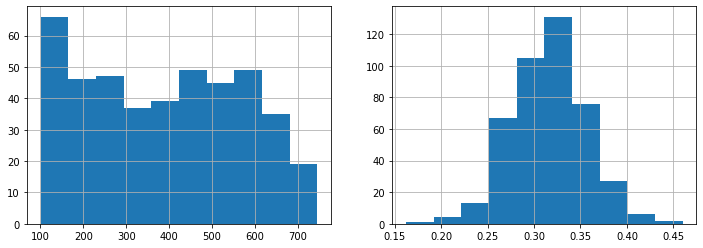

<IPython.core.display.Javascript object>

In [91]:
f_batter, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
df_batting_100pa["PA"].hist(ax=ax1)
ax1.set_xlabel('Number of plate appearances')
ax1.set_ylabel('Number of players')

df_batting_100pa["OBP"].hist(ax=ax2)
ax2.set_xlabel('On-base percentage')
ax2.set_ylabel('Number of players')

In [92]:
len(df_batting_100pa["key_mlbam"].unique())

432

<IPython.core.display.Javascript object>

In [ ]:
# Who are the lower OBPs?


## Pitcher stats -  to get a quick filter of pitchers

- may have to engineer the OBP directly for a pitcher
- just do WHIP for now
- I could probably due a better filter than 100 ip but will leave it alone

In [93]:
sql_query = """
SELECT * FROM pitching_stats_wpid;
"""

print(sql_query)

df_pitching = pd.read_sql_query(sql_query, con)
df_pitching = df_pitching[df_pitching["Season"] == 2018].copy()

df_pitching.drop(["index"], axis=1)


SELECT * FROM pitching_stats_wpid;



,Season,Name,Team,Age,W,L,ERA,WAR,G,GS,...,first_name,last_name,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,2018.0,Jacob deGrom,Mets,30.0,10.0,9.0,1.70,9.0,32.0,32.0,...,jacob,degrom,degrom,jacob,594798.0,degrj001,degroja01,10954.0,2014.0,2019.0
2,2018.0,Max Scherzer,Nationals,33.0,18.0,7.0,2.53,7.5,33.0,33.0,...,max,scherzer,scherzer,max,453286.0,schem001,scherma01,3137.0,2008.0,2019.0
4,2018.0,Scott Kingery,Phillies,24.0,0.0,0.0,13.50,0.0,1.0,0.0,...,scott,kingery,kingery,scott,664068.0,kings001,kingesc01,17975.0,2018.0,2019.0
8,2018.0,Justin Verlander,Astros,35.0,16.0,9.0,2.52,6.6,34.0,34.0,...,justin,verlander,verlander,justin,434378.0,verlj001,verlaju01,8700.0,2005.0,2019.0
12,2018.0,Chris Sale,Red Sox,29.0,12.0,4.0,2.11,6.2,27.0,27.0,...,chris,sale,sale,chris,519242.0,salec001,salech01,10603.0,2010.0,2019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2334,2018.0,Blaine Boyer,Royals,36.0,2.0,1.0,12.05,-0.8,21.0,0.0,...,blaine,boyer,boyer,blaine,430641.0,boyeb001,boyerbl01,2237.0,2005.0,2018.0
2336,2018.0,Brandon Maurer,Royals,27.0,0.0,4.0,7.76,-0.8,37.0,0.0,...,brandon,maurer,maurer,brandon,543506.0,maurb001,maurebr01,4878.0,2013.0,2018.0
2341,2018.0,Matt Albers,Brewers,35.0,3.0,3.0,7.34,-0.9,34.0,0.0,...,matt,albers,albers,matt,458006.0,albem001,alberma01,4300.0,2006.0,2019.0
2359,2018.0,Jarlin Garcia,Marlins,25.0,3.0,3.0,4.91,-1.3,29.0,7.0,...,jarlin,garcia,garcia,jarlin,606424.0,garcj006,garcija04,18282.0,2017.0,2019.0


<IPython.core.display.Javascript object>

In [68]:
# Aggregate over 2015-2019

# 100 IP, aggregated
# df_pitching1519agg_100ip = pitching_stats(2015, 2019, qual=100, ind=0)

<IPython.core.display.Javascript object>

In [76]:
# first_name_list = list()
# last_name_list = list()

# for name in df_pitching1519agg_100ip["Name"]:
#     name_list = name.split()
#     if len(name_list) > 2:
#         print(name_list)
#         if (name_list[2] is "Jr.") or (name_list[2] is "II"):
#             this_first_name = name_list[0]
#             this_last_name = name_list[1]
#         elif "Rosa" in name_list:
#             this_first_name = name_list[0]
#             this_last_name = name_list[1] + " " + name_list[2] + " " + name_list[3]
#         elif "Gonzalez" in name_list:
#             this_first_name = name_list[0] + name_list[1]
#             this_last_name = name_list[2]
#         elif "Smith" in name_list:
#             this_first_name = name_list[0]
#             this_last_name = name_list[2]

#     else:
#         this_first_name = name_list[0]
#         this_last_name = name_list[1]

#     first_name_list.append(this_first_name.lower())
#     last_name_list.append(this_last_name.lower())

['Lance', 'McCullers', 'Jr.']
['Carl', 'Edwards', 'Jr.']
['Jorge', 'De', 'La', 'Rosa']
['Rubby', 'de', 'la', 'Rosa']
['Robbie', 'Ross', 'Jr.']
['Chi', 'Chi', 'Gonzalez']
['Mike', 'Wright', 'Jr.']
['Josh', 'A.', 'Smith']


<IPython.core.display.Javascript object>

In [77]:
# df_pitching1519agg_100ip["firstname4pid"] = first_name_list
# df_pitching1519agg_100ip["lastname4pid"] = last_name_list

# df_pitching1519agg_100ip_wpid = pd.merge(
#     df_pitching1519agg_100ip,
#     df_player_id,
#     left_on=["lastname4pid", "firstname4pid"],
#     right_on=["name_last", "name_first"],
# )

# df_pitching1519agg_100ip_wpid.shape

<IPython.core.display.Javascript object>

In [95]:
df_pitching_50ip = df_pitching[df_pitching["IP"] > 50].copy()

<IPython.core.display.Javascript object>

In [96]:
df_pitching_50ip.head()

,index,Season,Name,Team,Age,W,L,ERA,WAR,G,...,first_name,last_name,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,0,2018.0,Jacob deGrom,Mets,30.0,10.0,9.0,1.70,9.0,32.0,...,jacob,degrom,degrom,jacob,594798.0,degrj001,degroja01,10954.0,2014.0,2019.0
2,2,2018.0,Max Scherzer,Nationals,33.0,18.0,7.0,2.53,7.5,33.0,...,max,scherzer,scherzer,max,453286.0,schem001,scherma01,3137.0,2008.0,2019.0
8,7,2018.0,Justin Verlander,Astros,35.0,16.0,9.0,2.52,6.6,34.0,...,justin,verlander,verlander,justin,434378.0,verlj001,verlaju01,8700.0,2005.0,2019.0
12,11,2018.0,Chris Sale,Red Sox,29.0,12.0,4.0,2.11,6.2,27.0,...,chris,sale,sale,chris,519242.0,salec001,salech01,10603.0,2010.0,2019.0
14,13,2018.0,Gerrit Cole,Astros,27.0,15.0,5.0,2.88,6.0,32.0,...,gerrit,cole,cole,gerrit,543037.0,coleg001,colege01,13125.0,2013.0,2019.0


<IPython.core.display.Javascript object>

## Merge statcast, batting, pitching dfs

In [82]:
df_sc_events_all.head()

,game_date,batter,pitcher,events,stand,p_throws,inning_topbot
0,2015-10-04,150029.0,544727.0,field_out,R,R,Top
1,2015-10-04,547180.0,544727.0,double,L,R,Top
2,2015-10-04,607208.0,544727.0,strikeout,R,R,Top
3,2015-10-04,543685.0,544727.0,field_out,R,R,Top
4,2015-10-04,502517.0,595014.0,grounded_into_double_play,L,R,Bot


<IPython.core.display.Javascript object>

In [98]:
# Merge statcast data to batter characteristics
colbatter2get = ["WAR", "OBP", "SLG", "OPS", "BB_perc", "K_perc", "key_mlbam"]

df_sc_events_all_b = pd.merge(
    df_sc_events_all,
    df_batting_100pa[colbatter2get],
    left_on="batter",
    right_on="key_mlbam",
)

<IPython.core.display.Javascript object>

In [100]:
# Merge pitcher characteristics
colpitcher2get = ["WAR", "WHIP", "ERA", "BB/9", "K/9", "HR/9", "key_mlbam"]

df_sc_events_all_bp = pd.merge(
    df_sc_events_all_b,
    df_pitching_50ip[colpitcher2get],
    left_on="pitcher",
    right_on="key_mlbam",
)

<IPython.core.display.Javascript object>

In [101]:
df_sc_events_all_bp.shape

(413566, 21)

<IPython.core.display.Javascript object>

In [102]:
df_sc_events_all_bp.head()

,game_date,batter,pitcher,events,stand,p_throws,inning_topbot,WAR_x,OBP,SLG,...,BB_perc,K_perc,key_mlbam_x,WAR_y,WHIP,ERA,BB/9,K/9,HR/9,key_mlbam_y
0,2015-10-04,547180.0,544727.0,double,L,R,Top,3.4,0.393,0.496,...,0.187,0.243,547180,1.8,1.22,3.13,3.5,10.38,0.38,544727.0
1,2015-09-08,547180.0,544727.0,walk,L,R,Bot,3.4,0.393,0.496,...,0.187,0.243,547180,1.8,1.22,3.13,3.5,10.38,0.38,544727.0
2,2015-09-07,547180.0,544727.0,strikeout,L,R,Bot,3.4,0.393,0.496,...,0.187,0.243,547180,1.8,1.22,3.13,3.5,10.38,0.38,544727.0
3,2015-07-21,547180.0,544727.0,hit_by_pitch,L,R,Bot,3.4,0.393,0.496,...,0.187,0.243,547180,1.8,1.22,3.13,3.5,10.38,0.38,544727.0
4,2015-05-03,547180.0,544727.0,strikeout,L,R,Top,3.4,0.393,0.496,...,0.187,0.243,547180,1.8,1.22,3.13,3.5,10.38,0.38,544727.0


<IPython.core.display.Javascript object>

In [103]:
df_sc_events_all_bp.groupby(["stand", "p_throws"]).count()

game_date  batter  pitcher  events  inning_topbot   WAR_x  \
stand p_throws                                                              
L     L             31479   31479    31479   31479          31479   31479   
      R            140603  140603   140603  140603         140603  140603   
R     L             85516   85516    85516   85516          85516   85516   
      R            155968  155968   155968  155968         155968  155968   

                   OBP     SLG     OPS  BB_perc  K_perc  key_mlbam_x   WAR_y  \
stand p_throws                                                                 
L     L          31479   31479   31479    31479   31479        31479   31479   
      R         140603  140603  140603   140603  140603       140603  140603   
R     L          85516   85516   85516    85516   85516        85516   85516   
      R         155968  155968  155968   155968  155968       155968  155968   

                  WHIP     ERA    BB/9     K/9    HR/9  key_mlbam_y  
stand p_throws                                                       
L     L          31479   31479   31479   31479   31479        31479  
      R         140603  140603  140603  140603  140603       140603  
R     L          85516   85516   85516   85516   85516        85516  
      R         155968  155968  155968  155968  155968       155968

<IPython.core.display.Javascript object>

### Start encoding for feeding into model

In [1241]:
df_sc_events_all_bp.head()

,game_date,batter,pitcher,events,stand,p_throws,inning_topbot,WAR_x,OBP,SLG,...,BB_perc,K_perc,key_mlbam_x,WAR_y,WHIP,ERA,BB/9,K/9,HR/9,key_mlbam_y
0,2015-10-04,547180.0,544727.0,double,L,R,Top,3.4,0.393,0.496,...,0.187,0.243,547180,1.8,1.22,3.13,3.5,10.38,0.38,544727.0
1,2015-09-08,547180.0,544727.0,walk,L,R,Bot,3.4,0.393,0.496,...,0.187,0.243,547180,1.8,1.22,3.13,3.5,10.38,0.38,544727.0
2,2015-09-07,547180.0,544727.0,strikeout,L,R,Bot,3.4,0.393,0.496,...,0.187,0.243,547180,1.8,1.22,3.13,3.5,10.38,0.38,544727.0
3,2015-07-21,547180.0,544727.0,hit_by_pitch,L,R,Bot,3.4,0.393,0.496,...,0.187,0.243,547180,1.8,1.22,3.13,3.5,10.38,0.38,544727.0
4,2015-05-03,547180.0,544727.0,strikeout,L,R,Top,3.4,0.393,0.496,...,0.187,0.243,547180,1.8,1.22,3.13,3.5,10.38,0.38,544727.0


<IPython.core.display.Javascript object>

In [222]:
df_sc_events4model_bp = df_sc_events_all_bp.copy()

<IPython.core.display.Javascript object>

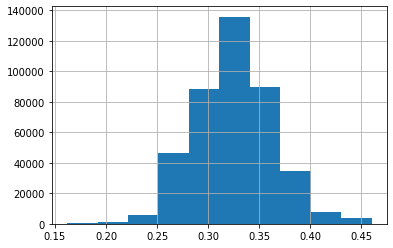

<IPython.core.display.Javascript object>

In [700]:
df_sc_events4model_bp["OBP"].hist()

In [223]:
# Encode events
event_list = ["hit_by_pitch", "walk", "single", "double", "triple", "home_run"]
df_sc_events4model_bp["event_code"] = 0
df_sc_events4model_bp.loc[
    df_sc_events4model_bp["events"].isin(event_list), "event_code"
] = 1

<IPython.core.display.Javascript object>

In [224]:
df_sc_events4model_bp["stand"].replace({"L": 0, "R": 1}, inplace=True)
df_sc_events4model_bp["p_throws"].replace({"L": 0, "R": 1}, inplace=True)
df_sc_events4model_bp["inning_topbot"].replace({"Top": 0, "Bot": 1}, inplace=True)

<IPython.core.display.Javascript object>

# Regression models with two features, target is historical proportion

## What happens historically when batter with 10% OBP meets a pitcher with 12% OBP?

In [285]:
df_sc_events4model_bp.head()

,game_date,batter,pitcher,events,stand,p_throws,inning_topbot,WAR_x,OBP,SLG,...,WAR_y,WHIP,ERA,BB/9,K/9,HR/9,key_mlbam_y,event_code,OBP_cat,WHIP_cat
0,2015-10-04,547180.0,544727.0,double,0,1,0,3.4,0.393,0.496,...,1.8,1.22,3.13,3.5,10.38,0.38,544727.0,1,"(0.378, 0.394]","(1.21, 1.24]"
1,2015-09-08,547180.0,544727.0,walk,0,1,1,3.4,0.393,0.496,...,1.8,1.22,3.13,3.5,10.38,0.38,544727.0,1,"(0.378, 0.394]","(1.21, 1.24]"
2,2015-09-07,547180.0,544727.0,strikeout,0,1,1,3.4,0.393,0.496,...,1.8,1.22,3.13,3.5,10.38,0.38,544727.0,0,"(0.378, 0.394]","(1.21, 1.24]"
3,2015-07-21,547180.0,544727.0,hit_by_pitch,0,1,1,3.4,0.393,0.496,...,1.8,1.22,3.13,3.5,10.38,0.38,544727.0,1,"(0.378, 0.394]","(1.21, 1.24]"
4,2015-05-03,547180.0,544727.0,strikeout,0,1,0,3.4,0.393,0.496,...,1.8,1.22,3.13,3.5,10.38,0.38,544727.0,0,"(0.378, 0.394]","(1.21, 1.24]"


<IPython.core.display.Javascript object>

## Bin each group and plot

In [286]:
# Bin these so that the most frequent categories are subdivided more
df_sc_events4model_bp["OBP_cat"] = pd.qcut(df_sc_events4model_bp["OBP"], 25)
df_sc_events4model_bp["WHIP_cat"] = pd.qcut(df_sc_events4model_bp["WHIP"], 25)

<IPython.core.display.Javascript object>

In [287]:
df_sc_events4model_bp.head()

,game_date,batter,pitcher,events,stand,p_throws,inning_topbot,WAR_x,OBP,SLG,...,WAR_y,WHIP,ERA,BB/9,K/9,HR/9,key_mlbam_y,event_code,OBP_cat,WHIP_cat
0,2015-10-04,547180.0,544727.0,double,0,1,0,3.4,0.393,0.496,...,1.8,1.22,3.13,3.5,10.38,0.38,544727.0,1,"(0.378, 0.394]","(1.21, 1.24]"
1,2015-09-08,547180.0,544727.0,walk,0,1,1,3.4,0.393,0.496,...,1.8,1.22,3.13,3.5,10.38,0.38,544727.0,1,"(0.378, 0.394]","(1.21, 1.24]"
2,2015-09-07,547180.0,544727.0,strikeout,0,1,1,3.4,0.393,0.496,...,1.8,1.22,3.13,3.5,10.38,0.38,544727.0,0,"(0.378, 0.394]","(1.21, 1.24]"
3,2015-07-21,547180.0,544727.0,hit_by_pitch,0,1,1,3.4,0.393,0.496,...,1.8,1.22,3.13,3.5,10.38,0.38,544727.0,1,"(0.378, 0.394]","(1.21, 1.24]"
4,2015-05-03,547180.0,544727.0,strikeout,0,1,0,3.4,0.393,0.496,...,1.8,1.22,3.13,3.5,10.38,0.38,544727.0,0,"(0.378, 0.394]","(1.21, 1.24]"


<IPython.core.display.Javascript object>

In [288]:
# Get the proportion from each category combination with groupby
df_sc_events4model_bp_agg = df_sc_events4model_bp.groupby(["OBP_cat", "WHIP_cat"])[
    "event_code"
].mean()

<IPython.core.display.Javascript object>

In [289]:
df_sc_events4model_bp_agg

OBP_cat        WHIP_cat     
(0.161, 0.26]  (0.789, 0.91]    0.221154
               (0.91, 0.99]     0.263848
               (0.99, 1.04]     0.269930
               (1.04, 1.08]     0.271264
               (1.08, 1.1]      0.268595
                                  ...   
(0.394, 0.46]  (1.41, 1.45]     0.364952
               (1.45, 1.49]     0.399632
               (1.49, 1.53]     0.391555
               (1.53, 1.62]     0.436207
               (1.62, 1.8]      0.382696
Name: event_code, Length: 625, dtype: float64

<IPython.core.display.Javascript object>

In [290]:
bat_cat_mp = pd.Series(
    df_sc_events4model_bp_agg.index.get_level_values(0).tolist()
).apply(lambda x: x.mid)
pitch_cat_mp = pd.Series(
    df_sc_events4model_bp_agg.index.get_level_values(1).tolist()
).apply(lambda x: x.mid)

df_sc_events4model_bp_agg_4model = pd.DataFrame(
    {
        "event_mean": df_sc_events4model_bp_agg.tolist(),
        "batter_cat": bat_cat_mp,
        "pitcher_cat": pitch_cat_mp,
    }
)

<IPython.core.display.Javascript object>

In [871]:
bat_cat_mp_4_bin = (
    pd.Series(df_sc_events4model_bp_agg.index.get_level_values(0).tolist())
    .apply(lambda x: x.left)
    .unique()
)

bat_cat_mp_4_bin_r = (
    pd.Series(df_sc_events4model_bp_agg.index.get_level_values(0).tolist())
    .apply(lambda x: x.right)
    .unique()
)
all_bin_sep = bat_cat_mp_4_bin.tolist() + bat_cat_mp_4_bin_r.tolist()

<IPython.core.display.Javascript object>

In [878]:
pitch_cat_mp_4_bin = (
    pd.Series(df_sc_events4model_bp_agg.index.get_level_values(1).tolist())
    .apply(lambda x: x.left)
    .unique()
)

pitch_cat_mp_4_bin_r = (
    pd.Series(df_sc_events4model_bp_agg.index.get_level_values(1).tolist())
    .apply(lambda x: x.right)
    .unique()
)
all_bin_sep_p = pitch_cat_mp_4_bin.tolist() + pitch_cat_mp_4_bin_r.tolist()

<IPython.core.display.Javascript object>

In [879]:
df_sc_events4model_bp.shape

(413566, 24)

<IPython.core.display.Javascript object>

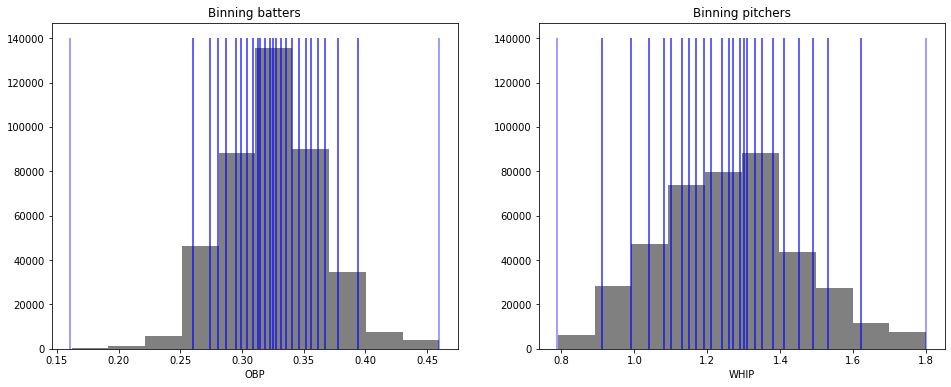

<IPython.core.display.Javascript object>

In [882]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
df_sc_events4model_bp["OBP"].hist(ax=ax1, color="gray")
ax1.vlines(all_bin_sep, 0, 140000, color="blue", alpha=0.5)
ax1.set_title("Binning batters")
ax1.set_xlabel("OBP")
ax1.grid(False)

df_sc_events4model_bp["WHIP"].hist(ax=ax2, color="gray")
ax2.vlines(all_bin_sep_p, 0, 140000, color="blue", alpha=0.5)
ax2.set_title("Binning pitchers")
ax2.set_xlabel("WHIP")
ax2.grid(False)

In [291]:
df_sc_events4model_bp_agg_4model

,event_mean,batter_cat,pitcher_cat
0,0.221154,0.2105,0.8495
1,0.263848,0.2105,0.9500
2,0.269930,0.2105,1.0150
3,0.271264,0.2105,1.0600
4,0.268595,0.2105,1.0900
...,...,...,...
620,0.364952,0.4270,1.4300
621,0.399632,0.4270,1.4700
622,0.391555,0.4270,1.5100
623,0.436207,0.4270,1.5750


<IPython.core.display.Javascript object>

In [120]:
# Imput missing data - not necessary
# https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html

<IPython.core.display.Javascript object>

Text(0, 0.5, 'proportion getting on-base')

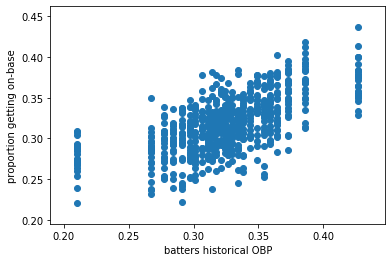

<IPython.core.display.Javascript object>

In [292]:
f, ax1 = plt.subplots()
ax1.scatter(
    df_sc_events4model_bp_agg_4model["batter_cat"],
    df_sc_events4model_bp_agg_4model["event_mean"],
)
ax1.set_xlabel("batters historical OBP")
ax1.set_ylabel("proportion getting on-base")

Text(0, 0.5, 'proportion getting on-base')

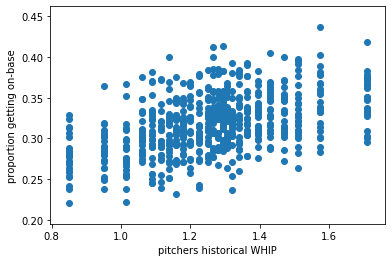

<IPython.core.display.Javascript object>

In [293]:
f, ax1 = plt.subplots()
ax1.scatter(
    df_sc_events4model_bp_agg_4model["pitcher_cat"],
    df_sc_events4model_bp_agg_4model["event_mean"],
)
ax1.set_xlabel("pitchers historical WHIP")
ax1.set_ylabel("proportion getting on-base")

Text(0, 0.5, 'pitcher WHIP')

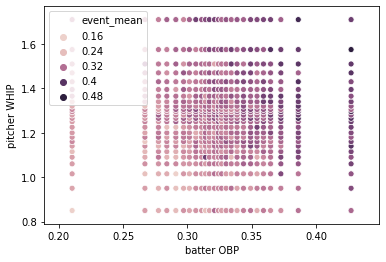

<IPython.core.display.Javascript object>

In [295]:
f, ax1 = plt.subplots()
sns.scatterplot(
    data=df_sc_events4model_bp_agg_4model,
    x="batter_cat",
    y="pitcher_cat",
    hue="event_mean",
    ax=ax1,
)  # , legend=False)

ax1.set_xlabel("batter OBP")
ax1.set_ylabel("pitcher WHIP")

## 3D plot

In [296]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

<IPython.core.display.Javascript object>

/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  


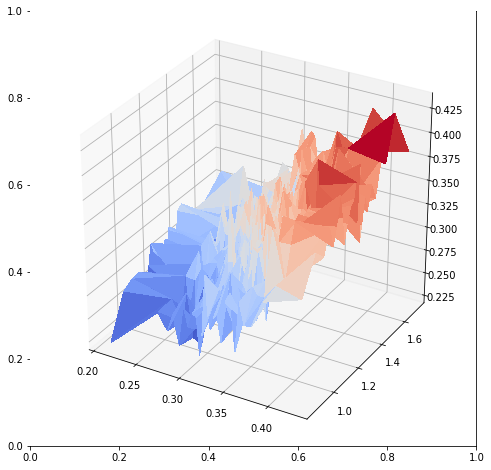

<IPython.core.display.Javascript object>

In [297]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = fig.gca(projection="3d")

# Plot the surface.
X = df_sc_events4model_bp_agg_4model["batter_cat"]
Y = df_sc_events4model_bp_agg_4model["pitcher_cat"]
Z = df_sc_events4model_bp_agg_4model["event_mean"]

# surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
surf = ax.plot_trisurf(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
# fig.colorbar(surf, shrink=0.5, aspect=5)

# plt.show()

## Linear regression model


In [298]:
def get_split_data(X, y, testsize):

    # Split data between train and test_and_holdout
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=testsize, random_state=19
    )
    from sklearn import preprocessing

    # Scale features based on training data
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scale = scaler.transform(X_train)

    # Apply transformation to test data
    X_test_scale = scaler.transform(X_test)

    return X_train_scale, X_test_scale, y_train, y_test, scaler

<IPython.core.display.Javascript object>

In [1244]:
df_sc_events4model_bp_agg_4model.head()

,event_mean,batter_cat,pitcher_cat
0,0.221154,0.2105,0.8495
1,0.263848,0.2105,0.9500
2,0.269930,0.2105,1.0150
3,0.271264,0.2105,1.0600
4,0.268595,0.2105,1.0900


<IPython.core.display.Javascript object>

In [299]:
feature_list = ["batter_cat", "pitcher_cat"]
target_col = "event_mean"

X_train_scale_d, X_test_scale_d, y_train_d, y_test_d, scaler_d = get_split_data(
    df_sc_events4model_bp_agg_4model[feature_list],
    df_sc_events4model_bp_agg_4model[target_col],
    0.4,
)

<IPython.core.display.Javascript object>

In [300]:
def run_linreg_model(X_train_scale_set, y_train_set, X_test_scale_set, y_test_set):

    lin_reg = LinearRegression()
    lin_reg.fit(X_train_scale_set, y_train_set)

    y_pred = lin_reg.predict(X_test_scale_set)
    df_eval = pd.DataFrame({"test": y_test_set, "pred": y_pred})

    return lin_reg, df_eval

<IPython.core.display.Javascript object>

In [301]:
lin_reg_v0, df_eval_v0 = run_linreg_model(
    X_train_scale_d, y_train_d, X_test_scale_d, y_test_d
)

<IPython.core.display.Javascript object>

In [302]:
lin_reg_v0.coef_

array([0.02276625, 0.01623917])

<IPython.core.display.Javascript object>

In [303]:
df_eval_v0

,test,pred
574,0.337190,0.381983
601,0.363770,0.345416
104,0.244851,0.285871
278,0.312102,0.299082
261,0.309453,0.313288
...,...,...
419,0.312139,0.337050
414,0.338759,0.328465
542,0.382090,0.346009
333,0.333676,0.312278


<IPython.core.display.Javascript object>

In [304]:
metrics.r2_score(df_eval_v0["test"], df_eval_v0["pred"])

0.6151561338489827

<IPython.core.display.Javascript object>

see what r2 score is by just predicting median

In [305]:
df_eval_v0_mean = df_eval_v0.copy()
df_eval_v0_mean["test_median"] = df_eval_v0_mean["test"].median()

<IPython.core.display.Javascript object>

In [306]:
metrics.r2_score(df_eval_v0_mean["test"], df_eval_v0_mean["test_median"])

-0.00861302581606771

<IPython.core.display.Javascript object>

### Enter a test case

In [307]:
np.array(new_vals)

array([[0.25, 1.6 ]])

<IPython.core.display.Javascript object>

In [308]:
# Note list within list for numpy and scaler recognizance
new_vals = [[0.25, 1.6]]
new_vals_scaled = scaler_d.transform(np.array(new_vals))

<IPython.core.display.Javascript object>

In [309]:
lin_reg_v0.predict(new_vals_scaled)

array([0.30807913])

<IPython.core.display.Javascript object>

In [310]:
stdev_y = np.sqrt(
    sum((lin_reg_v0.predict(X_train_scale_d) - y_train_d) ** 2) / (len(y_train_d) - 2)
)

print(stdev_y)

0.021163257169081233


<IPython.core.display.Javascript object>

In [187]:
## prediction interval
# https://towardsdatascience.com/how-to-generate-prediction-intervals-with-scikit-learn-and-python-ab3899f992ed

<IPython.core.display.Javascript object>

### Test case with names

In [1350]:
def return_matchup_results_of_batter_pitcher(batter_name, pitcher_name):

    batter_obp = np.float(
        df_batting_stats_wpid.loc[df_batting_stats_wpid["Name"] == batter, "OBP"]
    )
    # print(batter_obp)

    pitcher_whip = np.float(
        df_pitching_stats_wpid.loc[df_pitching_stats_wpid["Name"] == pitcher, "WHIP"]
    )
    # print(pitcher_whip)

    # Note list within list for numpy and scaler recognizance
    bp_test_vals = [[batter_obp, pitcher_whip]]
    bp_vals_scaled = scaler_d.transform(np.array(bp_test_vals))

    bp_pred = lin_reg_v0.predict(bp_vals_scaled)
    bp_stdev_y = np.sqrt(
        sum((lin_reg_v0.predict(X_train_scale_d) - y_train_d) ** 2)
        / (len(y_train_d) - 2)
    )

    return [batter_obp, pitcher_whip]



<IPython.core.display.Javascript object>

In [1351]:
return_matchup_results_of_batter_pitcher("Mike Trout", "Gerrit Cole")

[0.46, 1.03]

<IPython.core.display.Javascript object>

In [806]:
def return_matchup_results(batter_name, pitcher_name):

    batter_obp = np.float(
        df_batting_stats_wpid.loc[df_batting_stats_wpid["Name"] == batter, "OBP"]
    )
    # print(batter_obp)

    pitcher_whip = np.float(
        df_pitching_stats_wpid.loc[df_pitching_stats_wpid["Name"] == pitcher, "WHIP"]
    )
    # print(pitcher_whip)

    # Note list within list for numpy and scaler recognizance
    bp_test_vals = [[batter_obp, pitcher_whip]]
    bp_vals_scaled = scaler_d.transform(np.array(bp_test_vals))

    bp_pred = lin_reg_v0.predict(bp_vals_scaled)
    bp_stdev_y = np.sqrt(
        sum((lin_reg_v0.predict(X_train_scale_d) - y_train_d) ** 2)
        / (len(y_train_d) - 2)
    )

    return str(np.around(bp_pred[0], 3)) + " +/- " + str(np.around(bp_stdev_y, 3))

<IPython.core.display.Javascript object>

In [807]:
return_matchup_results("Mike Trout", "Gerrit Cole")

'0.37 +/- 0.021'

<IPython.core.display.Javascript object>

In [810]:
df_batting_stats_wpid.shape

(955, 300)

<IPython.core.display.Javascript object>

In [1218]:
os.listdir()

['daily_fantasy_baseball_predictor_v4.ipynb',
 'flask_udemy',
 'daily_fantasy_baseball_predictor_v3_simple.ipynb',
 '.DS_Store',
 'daily_fantasy_baseball_predictor_v2.ipynb',
 'daily_fantasy_baseball_predictor_v5.ipynb',
 'daily_fantasy_baseball_predictor_v1.ipynb',
 'daily_fantasy_baseball_predictor_v2-Copy1.ipynb',
 'postgreSQL_notes.ipynb',
 '.ipynb_checkpoints',
 'player_pair_set_and_validation.ipynb',
 'other_dev_setup',
 '.git',
 'flask_insight_notes',
 'daily_fantasy_baseball_predictor.ipynb']

<IPython.core.display.Javascript object>

In [1228]:
# Write batting and pitching characteristics to CSV file
# df_batting_100pa.to_csv("flask_insight_notes/flask_baseball/df_batting_100pa.csv")
# df_pitching_50ip.to_csv("flask_insight_notes/flask_baseball/df_pitching_50ip.csv")

<IPython.core.display.Javascript object>

In [1239]:
def return_bp_histograms(batter_name, pitcher_name):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    df_batting_100pa["OBP"].hist(bins=20, color="gray", ax=ax1)
    obp_val = np.float(
        df_batting_100pa.loc[df_batting_100pa["Name"] == batter_name, "OBP"].iloc[0]
    )
    ax1.axvline(obp_val, 0, 100, c="red", linestyle=":")
    ax1.set_title("Batter: " + batter_name, color="red")
    ax1.set_xlabel("OBP")

    df_pitching_50ip["WHIP"].hist(bins=30, color="gray", ax=ax2)
    pitcher_whip = np.float(
        df_pitching_50ip.loc[df_pitching_50ip["Name"] == pitcher_name, "WHIP"]
    )
    ax2.axvline(pitcher_whip, 0, 100, c="red", linestyle=":")
    ax2.set_title("Pitcher: " + pitcher_name, color="red")
    ax2.set_xlabel("WHIP")

    save_name = (
        "hist_"
        + (batter_name).replace(" ", "-")
        + "_"
        + (pitcher_name).replace(" ", "-")
    )

    dir_path = "./flask_insight_notes/flask_baseball/flaskexample/static/bp_hist/"
    plt.savefig(dir_path + save_name)

    return save_name + ".png"

<IPython.core.display.Javascript object>

'hist_Mike-Trout_Gerrit-Cole.png'

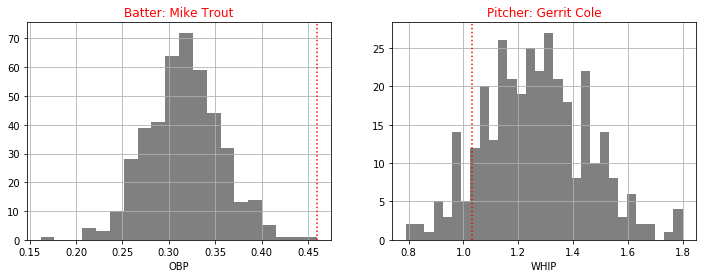

<IPython.core.display.Javascript object>

In [1355]:
return_bp_histograms("Mike Trout", "Gerrit Cole")

## Feed values into model and make heat map and 3D plot 

In [ ]:
# export heatmap results

In [1348]:
os.listdir()

['daily_fantasy_baseball_predictor_v4.ipynb',
 'flask_udemy',
 'daily_fantasy_baseball_predictor_v3_simple.ipynb',
 '.DS_Store',
 'daily_fantasy_baseball_predictor_v2.ipynb',
 'daily_fantasy_baseball_predictor_v5.ipynb',
 'daily_fantasy_baseball_predictor_v1.ipynb',
 'daily_fantasy_baseball_predictor_v2-Copy1.ipynb',
 'postgreSQL_notes.ipynb',
 '.ipynb_checkpoints',
 'player_pair_set_and_validation.ipynb',
 'other_dev_setup',
 '.git',
 'flask_insight_notes',
 'daily_fantasy_baseball_predictor.ipynb']

<IPython.core.display.Javascript object>

In [ ]:
# Make heatmap spreadsheet

bat_cat_min, bat_cat_max = 0.15, 0.5
pitch_cat_min, pitch_cat_max = 0.8, 1.8
n_points = 20

df_vals4heatmap = pd.DataFrame(
    {
        "batter_cat": sorted(
            np.linspace(bat_cat_min, bat_cat_max, n_points).tolist() * n_points
        ),
        "pitcher_cat": (
            np.linspace(pitch_cat_min, pitch_cat_max, n_points).tolist() * n_points
        ),
    }
)

# Scale values
df_vals4heatmap_scale = scaler_d.transform(df_vals4heatmap)

# Use model to make predictions
y_pred_vals4heatmap = lin_reg_v0.predict(df_vals4heatmap_scale)

df_vals4heatmap["pred"] = y_pred_vals4heatmap

In [1358]:
df_vals4heatmap.to_csv("flask_insight_notes/flask_baseball/df_vals4heatmap.csv")

<IPython.core.display.Javascript object>

In [1365]:
df_batting_100pa.tail()

,index,index_x,Season,Name,Team,Age,G,AB,PA,H,...,first_name,index_y,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
950,948,1897,2018.0,Pat Valaika,Rockies,25.0,68.0,122.0,133.0,19.0,...,pat,1813,valaika,pat,642162,valap001,valaipa01,14885,2016.0,2019.0
951,949,1335,2018.0,Yangervis Solarte,Blue Jays,30.0,122.0,468.0,506.0,106.0,...,yangervis,1660,solarte,yangervis,500208,solay001,solarya01,5352,2014.0,2019.0
952,952,1955,2018.0,Magneuris Sierra,Marlins,22.0,54.0,147.0,156.0,28.0,...,magneuris,1615,sierra,magneuris,642423,sierm002,sierrma01,17023,2017.0,2019.0
953,953,1365,2018.0,Victor Martinez,Tigers,39.0,133.0,467.0,508.0,117.0,...,victor,1100,martinez,victor,400121,martv001,martivi01,393,2002.0,2018.0
954,954,1719,2018.0,Chris Davis,Orioles,32.0,128.0,470.0,522.0,79.0,...,chris,411,davis,chris,448801,davic003,davisch02,9272,2008.0,2019.0


<IPython.core.display.Javascript object>

In [1375]:
def make_heatmap_w_input_mark(batter_name, pitcher_name):
    bat_cat_min, bat_cat_max = 0.15, 0.5
    pitch_cat_min, pitch_cat_max = 0.8, 1.8
    n_points = 20

    df_vals4heatmap = pd.read_csv(
        "flask_insight_notes/flask_baseball/df_vals4heatmap.csv"
    )

    df_vals4heatmap_pivot = df_vals4heatmap.pivot("batter_cat", "pitcher_cat", "pred")

    def fmt(s):
        try:
            n = "{:.3f}".format(float(s))
        except:
            n = ""
        return n

    f, ax1 = plt.subplots(figsize=(8, 8))
    ax1 = sns.heatmap(df_vals4heatmap_pivot, cmap="RdBu_r")  # , annot=True)
    ax1.set_xticklabels([fmt(label.get_text()) for label in ax1.get_xticklabels()])
    ax1.invert_yaxis()
    ax1.set_yticklabels([fmt(label.get_text()) for label in ax1.get_yticklabels()])

    batter_obp = np.float(
        df_batting_100pa.loc[df_batting_100pa["Name"] == batter_name, "OBP"]
    )

    pitcher_whip = np.float(
        df_pitching_50ip.loc[df_pitching_50ip["Name"] == pitcher_name, "WHIP"]
    )

    bat_val, pitch_val = batter_obp, pitcher_whip
    x_on_plot = (pitch_val / pitch_cat_max) * n_points
    y_on_plot = (bat_val / bat_cat_max) * n_points
    # ax1.scatter(x_on_plot, y_on_plot, marker="*", s=100, color="orange")

    save_name = (
        "heatmap_"
        + (batter_name).replace(" ", "-")
        + "_"
        + (pitcher_name).replace(" ", "-")
    )

    dir_path = "./flask_insight_notes/flask_baseball/flaskexample/static/bp_hist/"
    plt.savefig(dir_path + save_name)

    return save_name + ".png"

<IPython.core.display.Javascript object>

'heatmap_Chris-Davis_Justin-Verlander.png'

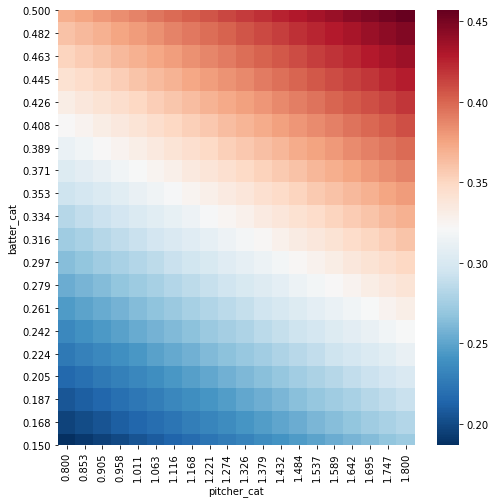

<IPython.core.display.Javascript object>

In [1376]:
make_heatmap_w_input_mark("Chris Davis", "Justin Verlander")

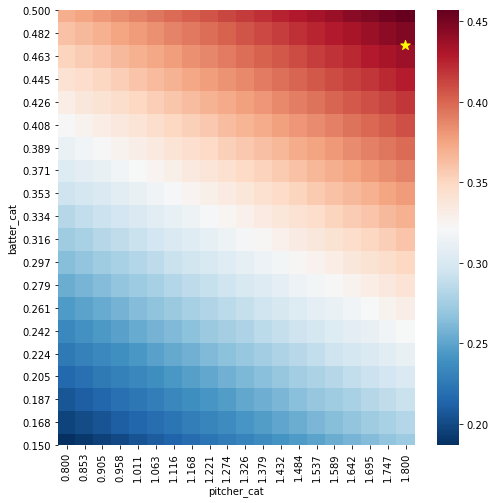

<IPython.core.display.Javascript object>

In [1347]:
# from matplotlib.ticker import FormatStrFormatter



In [1352]:
save_name

NameError: name 'save_name' is not defined

<IPython.core.display.Javascript object>

## Lasso regression model

In [283]:
from sklearn.linear_model import Lasso

<IPython.core.display.Javascript object>

In [311]:
def run_lassoreg_model(X_train_scale_set, y_train_set, X_test_scale_set, y_test_set):

    lasso_reg = Lasso()
    lasso_reg.fit(X_train_scale_set, y_train_set)

    y_pred = lasso_reg.predict(X_test_scale_set)
    df_eval = pd.DataFrame({"test": y_test_set, "pred": y_pred})

    return lasso_reg, df_eval

<IPython.core.display.Javascript object>

In [312]:
lasso_reg_v0, df_eval_lasso_v0 = run_lassoreg_model(
    X_train_scale_d, y_train_d, X_test_scale_d, y_test_d
)

<IPython.core.display.Javascript object>

In [313]:
df_eval_lasso_v0.head()

,test,pred
574,0.337190,0.318431
601,0.363770,0.318431
104,0.244851,0.318431
278,0.312102,0.318431
261,0.309453,0.318431


<IPython.core.display.Javascript object>

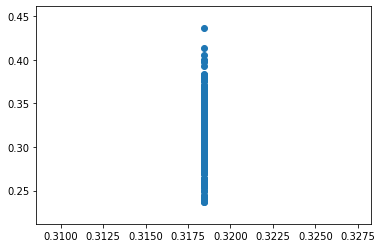

<IPython.core.display.Javascript object>

In [314]:
f, ax1 = plt.subplots()
ax1.scatter(df_eval_lasso_v0["pred"], df_eval_lasso_v0["test"])

In [315]:
metrics.r2_score(df_eval_lasso_v0["test"], df_eval_lasso_v0["pred"])

-0.0019602187533234172

<IPython.core.display.Javascript object>

## Ridge regression

In [319]:
from sklearn.linear_model import Ridge

<IPython.core.display.Javascript object>

In [320]:
def run_ridgereg_model(X_train_scale_set, y_train_set, X_test_scale_set, y_test_set):

    ridge_reg = Ridge()
    ridge_reg.fit(X_train_scale_set, y_train_set)

    y_pred = ridge_reg.predict(X_test_scale_set)
    df_eval = pd.DataFrame({"test": y_test_set, "pred": y_pred})

    return ridge_reg, df_eval

<IPython.core.display.Javascript object>

In [321]:
ridge_reg_v0, df_eval_ridge_v0 = run_ridgereg_model(
    X_train_scale_d, y_train_d, X_test_scale_d, y_test_d
)

<IPython.core.display.Javascript object>

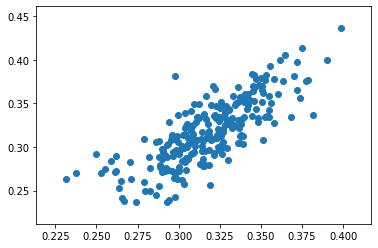

<IPython.core.display.Javascript object>

In [322]:
f, ax1 = plt.subplots()
ax1.scatter(df_eval_ridge_v0["pred"], df_eval_ridge_v0["test"])

In [323]:
metrics.r2_score(df_eval_ridge_v0["test"], df_eval_ridge_v0["pred"])

0.6150187066466597

<IPython.core.display.Javascript object>

# Regression modeling with additional bins

In [883]:
df_sc_events4model_bp.head()

,game_date,batter,pitcher,events,stand,p_throws,inning_topbot,WAR_x,OBP,SLG,...,WAR_y,WHIP,ERA,BB/9,K/9,HR/9,key_mlbam_y,event_code,OBP_cat,WHIP_cat
0,2015-10-04,547180.0,544727.0,double,0,1,0,3.4,0.393,0.496,...,1.8,1.22,3.13,3.5,10.38,0.38,544727.0,1,"(0.378, 0.394]","(1.21, 1.24]"
1,2015-09-08,547180.0,544727.0,walk,0,1,1,3.4,0.393,0.496,...,1.8,1.22,3.13,3.5,10.38,0.38,544727.0,1,"(0.378, 0.394]","(1.21, 1.24]"
2,2015-09-07,547180.0,544727.0,strikeout,0,1,1,3.4,0.393,0.496,...,1.8,1.22,3.13,3.5,10.38,0.38,544727.0,0,"(0.378, 0.394]","(1.21, 1.24]"
3,2015-07-21,547180.0,544727.0,hit_by_pitch,0,1,1,3.4,0.393,0.496,...,1.8,1.22,3.13,3.5,10.38,0.38,544727.0,1,"(0.378, 0.394]","(1.21, 1.24]"
4,2015-05-03,547180.0,544727.0,strikeout,0,1,0,3.4,0.393,0.496,...,1.8,1.22,3.13,3.5,10.38,0.38,544727.0,0,"(0.378, 0.394]","(1.21, 1.24]"


<IPython.core.display.Javascript object>

## OBP for each batter against a right and left handed pitcher

In [1068]:
def get_binned_data(index_col, bin_col, df):
    df_counts = (df.groupby([index_col, bin_col]).count()["event_code"]).unstack()
    df_counts.columns = [bin_col + "_counts_" + str(i) for i in df_counts.columns]
    df_event_mean = (df.groupby([index_col, bin_col]).mean()["event_code"]).unstack()
    df_event_mean.columns = [bin_col + "_prop_" + str(i) for i in df_event_mean.columns]
    df_binned = pd.merge(df_counts, df_event_mean, left_index=True, right_index=True)
    return df_binned

<IPython.core.display.Javascript object>

In [1069]:
df_binned = get_binned_data("batter", "p_throws", df_sc_events4model_bp)

<IPython.core.display.Javascript object>

In [943]:
df_binned.head()

,p_throws_counts_0,p_throws_counts_1,p_throws_prop_0,p_throws_prop_1
batter,,,,
134181.0,373.0,899.0,0.375335,0.329255
400121.0,345.0,822.0,0.339130,0.294404
400284.0,78.0,729.0,0.179487,0.303155
405395.0,513.0,1234.0,0.292398,0.295786
408045.0,383.0,1031.0,0.352480,0.329777


<IPython.core.display.Javascript object>

In [1070]:
df_sc_events4model_bp.head()

,game_date,batter,pitcher,events,stand,p_throws,inning_topbot,WAR_x,OBP,SLG,...,WAR_y,WHIP,ERA,BB/9,K/9,HR/9,key_mlbam_y,event_code,OBP_cat,WHIP_cat
0,2015-10-04,547180.0,544727.0,double,0,1,0,3.4,0.393,0.496,...,1.8,1.22,3.13,3.5,10.38,0.38,544727.0,1,"(0.378, 0.394]","(1.21, 1.24]"
1,2015-09-08,547180.0,544727.0,walk,0,1,1,3.4,0.393,0.496,...,1.8,1.22,3.13,3.5,10.38,0.38,544727.0,1,"(0.378, 0.394]","(1.21, 1.24]"
2,2015-09-07,547180.0,544727.0,strikeout,0,1,1,3.4,0.393,0.496,...,1.8,1.22,3.13,3.5,10.38,0.38,544727.0,0,"(0.378, 0.394]","(1.21, 1.24]"
3,2015-07-21,547180.0,544727.0,hit_by_pitch,0,1,1,3.4,0.393,0.496,...,1.8,1.22,3.13,3.5,10.38,0.38,544727.0,1,"(0.378, 0.394]","(1.21, 1.24]"
4,2015-05-03,547180.0,544727.0,strikeout,0,1,0,3.4,0.393,0.496,...,1.8,1.22,3.13,3.5,10.38,0.38,544727.0,0,"(0.378, 0.394]","(1.21, 1.24]"


<IPython.core.display.Javascript object>

## OBP for each pitcher against batter handedness

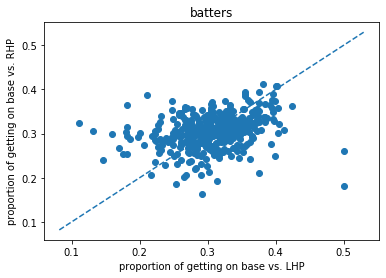

<IPython.core.display.Javascript object>

In [969]:
f, (ax1) = plt.subplots(1, 1)
ax1.scatter(df_binned["p_throws_prop_0"], df_binned["p_throws_prop_1"])
ax1.set_title("batters")
ax1.set_xlabel("proportion of getting on base vs. LHP")
ax1.set_ylabel("proportion of getting on base vs. RHP")
abline(1, 0, ax1)


In [944]:
df_sc_events4model_bp_pbin = pd.merge(
    df_sc_events4model_bp, df_binned, left_on="batter", right_index=True
)

<IPython.core.display.Javascript object>

In [946]:
df_binned_p = get_binned_data("pitcher", "stand", df_sc_events4model_bp)

<IPython.core.display.Javascript object>

In [956]:
df_binned_p.head()

,stand_counts_0,stand_counts_1,stand_prop_0,stand_prop_1
pitcher,,,,
112526.0,1033,996,0.327202,0.332329
282332.0,523,2024,0.315488,0.328063
407845.0,485,499,0.327835,0.338677
425492.0,338,390,0.301775,0.274359
425844.0,1472,1458,0.289402,0.280521


<IPython.core.display.Javascript object>

In [963]:
# from stack overflow
def abline(slope, intercept, ax):
    """Plot a line from slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, "--")

<IPython.core.display.Javascript object>

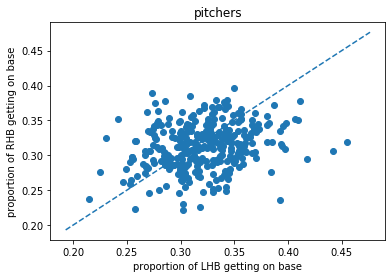

<IPython.core.display.Javascript object>

In [970]:
f, (ax1) = plt.subplots(1, 1)
ax1.scatter(df_binned_p["stand_prop_0"], df_binned_p["stand_prop_1"])
ax1.set_title("pitchers")
ax1.set_xlabel("proportion of LHB getting on base")
ax1.set_ylabel("proportion of RHB getting on base")
abline(1, 0, ax1)


In [951]:
df_sc_events4model_bp_pbin_bbin = pd.merge(
    df_sc_events4model_bp_pbin, df_binned_p, left_on="pitcher", right_index=True
)

<IPython.core.display.Javascript object>

In [1139]:
df_binned.head()

,p_throws_counts_0,p_throws_counts_1,p_throws_prop_0,p_throws_prop_1
batter,,,,
134181.0,373.0,899.0,0.375335,0.329255
400121.0,345.0,822.0,0.339130,0.294404
400284.0,78.0,729.0,0.179487,0.303155
405395.0,513.0,1234.0,0.292398,0.295786
408045.0,383.0,1031.0,0.352480,0.329777


<IPython.core.display.Javascript object>

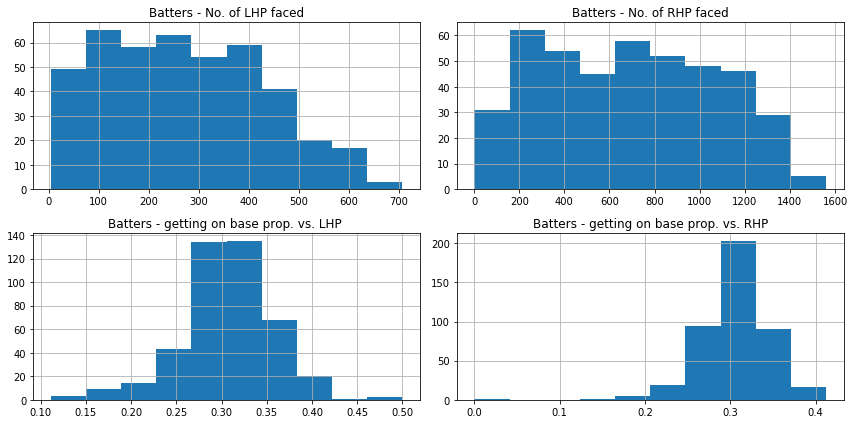

<IPython.core.display.Javascript object>

In [1140]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6))
df_binned["p_throws_counts_0"].hist(ax=ax1)
ax1.set_title("Batters - No. of LHP faced")

df_binned["p_throws_counts_1"].hist(ax=ax2)
ax2.set_title("Batters - No. of RHP faced")

df_binned["p_throws_prop_0"].hist(ax=ax3)
ax3.set_title("Batters - getting on base prop. vs. LHP ")

df_binned["p_throws_prop_1"].hist(ax=ax4)
ax4.set_title("Batters - getting on base prop. vs. RHP")

plt.tight_layout()

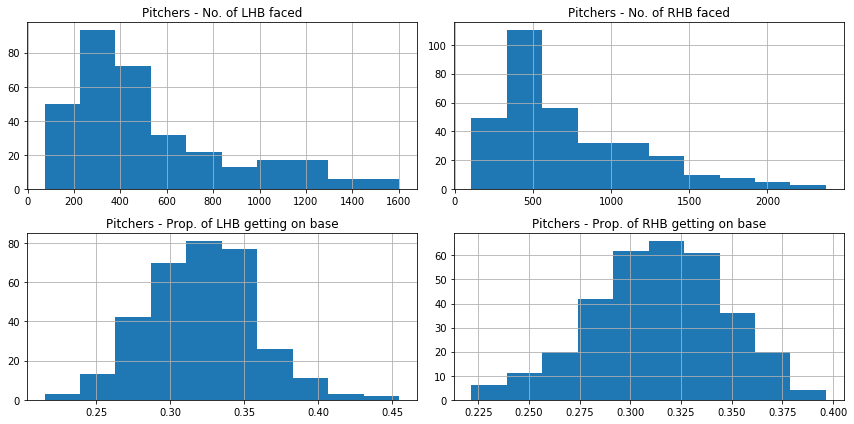

<IPython.core.display.Javascript object>

In [959]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 6))
df_binned_p["stand_counts_0"].hist(ax=ax1)
ax1.set_title("Pitchers - No. of LHB faced")

df_binned_p["stand_counts_1"].hist(ax=ax2)
ax2.set_title("Pitchers - No. of RHB faced")

df_binned_p["stand_prop_0"].hist(ax=ax3)
ax3.set_title("Pitchers - Prop. of LHB getting on base")

df_binned_p["stand_prop_1"].hist(ax=ax4)
ax4.set_title("Pitchers - Prop. of RHB getting on base")

plt.tight_layout()

In [968]:
df_sc_events4model_bp_pbin_bbin.head()

,game_date,batter,pitcher,events,stand,p_throws,inning_topbot,WAR_x,OBP,SLG,...,OBP_cat,WHIP_cat,p_throws_counts_0,p_throws_counts_1,p_throws_prop_0,p_throws_prop_1,stand_counts_0,stand_counts_1,stand_prop_0,stand_prop_1
0,2015-10-04,547180.0,544727.0,double,0,1,0,3.4,0.393,0.496,...,"(0.378, 0.394]","(1.21, 1.24]",490.0,1280.0,0.355102,0.385156,444,499,0.36036,0.306613
1,2015-09-08,547180.0,544727.0,walk,0,1,1,3.4,0.393,0.496,...,"(0.378, 0.394]","(1.21, 1.24]",490.0,1280.0,0.355102,0.385156,444,499,0.36036,0.306613
2,2015-09-07,547180.0,544727.0,strikeout,0,1,1,3.4,0.393,0.496,...,"(0.378, 0.394]","(1.21, 1.24]",490.0,1280.0,0.355102,0.385156,444,499,0.36036,0.306613
3,2015-07-21,547180.0,544727.0,hit_by_pitch,0,1,1,3.4,0.393,0.496,...,"(0.378, 0.394]","(1.21, 1.24]",490.0,1280.0,0.355102,0.385156,444,499,0.36036,0.306613
4,2015-05-03,547180.0,544727.0,strikeout,0,1,0,3.4,0.393,0.496,...,"(0.378, 0.394]","(1.21, 1.24]",490.0,1280.0,0.355102,0.385156,444,499,0.36036,0.306613


<IPython.core.display.Javascript object>

## Binning to categories

In [1059]:
def create_df_by_bp_hand(df, bat_h, pitch_h):
    bool_bp = (df["stand"] == bat_h) & (df["p_throws"] == pitch_h)
    df_by_hand = df.loc[bool_bp, :].copy()

    s_bp_prop = df_by_hand.groupby("batter").mean()["event_code"]
    s_bp_prop.name = "hist_BH" + str(bat_h) + "_obp_vs_" + "PH" + str(pitch_h)

    # Merge new batter info
    df_temp = pd.merge(df, s_bp_prop, left_on="batter", right_index=True)

    # Filter merged df by handededness
    bool_bp = (df_temp["stand"] == bat_h) & (df_temp["p_throws"] == pitch_h)
    df_by_hand = df_temp.loc[bool_bp, :].copy()

    return df_by_hand

<IPython.core.display.Javascript object>

In [1060]:
df_sc_events4model_bp_pbin_bbin_LB_LP = create_df_by_bp_hand(
    df_sc_events4model_bp_pbin_bbin, 0, 0
)
df_sc_events4model_bp_pbin_bbin_LB_RP = create_df_by_bp_hand(
    df_sc_events4model_bp_pbin_bbin, 0, 1
)
df_sc_events4model_bp_pbin_bbin_RB_LP = create_df_by_bp_hand(
    df_sc_events4model_bp_pbin_bbin, 1, 0
)
df_sc_events4model_bp_pbin_bbin_RB_RP = create_df_by_bp_hand(
    df_sc_events4model_bp_pbin_bbin, 1, 1
)

<IPython.core.display.Javascript object>

In [ ]:
# Target - historical OBP for the matchup
# Predictor - category of that batter's historical proportion against the pitcher hand

### Left-handed batter, left-handed pitcher

In [1061]:
df_sc_events4model_bp_pbin_bbin_LB_LP.head()

,game_date,batter,pitcher,events,stand,p_throws,inning_topbot,WAR_x,OBP,SLG,...,p_throws_prop_1,stand_counts_0,stand_counts_1,stand_prop_0,stand_prop_1,p_throws_prop_0_cat,p_throws_prop_1_cat,stand_prop_0_cat,stand_prop_1_cat,BH0_obp_vs_PH0
16024,2015-09-19,547180.0,543272.0,sac_fly,0,0,1,3.4,0.393,0.496,...,0.385156,433,759,0.230947,0.325428,"(0.355, 0.362]","(0.373, 0.412]","(0.214, 0.258]","(0.324, 0.327]",0.355102
16025,2015-09-19,547180.0,543272.0,field_out,0,0,1,3.4,0.393,0.496,...,0.385156,433,759,0.230947,0.325428,"(0.355, 0.362]","(0.373, 0.412]","(0.214, 0.258]","(0.324, 0.327]",0.355102
16026,2015-09-19,547180.0,543272.0,grounded_into_double_play,0,0,1,3.4,0.393,0.496,...,0.385156,433,759,0.230947,0.325428,"(0.355, 0.362]","(0.373, 0.412]","(0.214, 0.258]","(0.324, 0.327]",0.355102
16027,2015-09-13,547180.0,543272.0,force_out,0,0,0,3.4,0.393,0.496,...,0.385156,433,759,0.230947,0.325428,"(0.355, 0.362]","(0.373, 0.412]","(0.214, 0.258]","(0.324, 0.327]",0.355102
16028,2015-08-30,547180.0,543272.0,single,0,0,1,3.4,0.393,0.496,...,0.385156,433,759,0.230947,0.325428,"(0.355, 0.362]","(0.373, 0.412]","(0.214, 0.258]","(0.324, 0.327]",0.355102


<IPython.core.display.Javascript object>

In [1168]:
df_sc_events4model_bp_pbin_bbin_LB_LP.shape

(31479, 36)

<IPython.core.display.Javascript object>

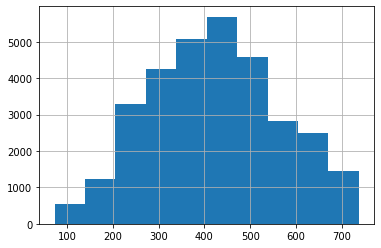

<IPython.core.display.Javascript object>

In [1103]:
df_sc_events4model_bp_pbin_bbin_LB_LP["stand_counts_0"].hist()

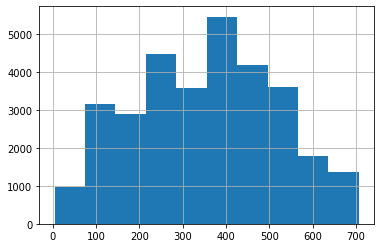

<IPython.core.display.Javascript object>

In [1104]:
df_sc_events4model_bp_pbin_bbin_LB_LP["p_throws_counts_0"].hist()

In [1109]:
# Only keep pitchers and batters with 300 at-bats each

bool300 = (df_sc_events4model_bp_pbin_bbin_LB_LP["stand_counts_0"] > 300) | (
    df_sc_events4model_bp_pbin_bbin_LB_LP["p_throws_counts_0"] > 300
)

<IPython.core.display.Javascript object>

In [1110]:
print("keep: ", bool300.sum())

keep:  28437


<IPython.core.display.Javascript object>

In [1107]:
df_sc_events4model_bp_pbin_bbin_LB_LP.shape

(31479, 36)

<IPython.core.display.Javascript object>

In [1111]:
df_sc_events4model_bp_pbin_bbin_LB_LP_300 = df_sc_events4model_bp_pbin_bbin_LB_LP.loc[
    bool300, :
].copy()

<IPython.core.display.Javascript object>

In [1074]:
# df_sc_events4model_bp_pbin_bbin_LB_LP.drop("BH0_obp_vs_PH0", axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [1112]:
# Get the proportion from each category combination with groupby
df_sc_events4model_bp_pbin_bbin_LB_LP_agg = df_sc_events4model_bp_pbin_bbin_LB_LP_300.groupby(['stand_prop_0_cat', 'p_throws_prop_0_cat'])['event_code'].mean()


<IPython.core.display.Javascript object>

In [1113]:
df_sc_events4model_bp_pbin_bbin_LB_LP_agg

stand_prop_0_cat  p_throws_prop_0_cat
(0.214, 0.258]    (0.11, 0.247]          0.117647
                  (0.247, 0.262]         0.190789
                  (0.262, 0.272]         0.252427
                  (0.272, 0.278]         0.244444
                  (0.278, 0.284]         0.250000
                                           ...   
(0.373, 0.455]    (0.355, 0.362]         0.405941
                  (0.362, 0.37]          0.346154
                  (0.37, 0.379]          0.550000
                  (0.379, 0.396]         0.428571
                  (0.396, 0.5]           0.521739
Name: event_code, Length: 625, dtype: float64

<IPython.core.display.Javascript object>

In [1114]:
bat_cat_mp_LL = pd.Series(
    df_sc_events4model_bp_pbin_bbin_LB_LP_agg.index.get_level_values(0).tolist()
).apply(lambda x: x.mid)

pitch_cat_mp_LL = pd.Series(
    df_sc_events4model_bp_pbin_bbin_LB_LP_agg.index.get_level_values(1).tolist()
).apply(lambda x: x.mid)
df_sc_events4model_bp_pbin_bbin_LB_LP_agg_4model = pd.DataFrame(
    {
        "event_mean": df_sc_events4model_bp_pbin_bbin_LB_LP_agg.tolist(),
        "batter_cat": bat_cat_mp_LL,
        "pitcher_cat": pitch_cat_mp_LL,
    }
)

<IPython.core.display.Javascript object>

In [1115]:
df_sc_events4model_bp_pbin_bbin_LB_LP_agg_4model.shape

(625, 3)

<IPython.core.display.Javascript object>

/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


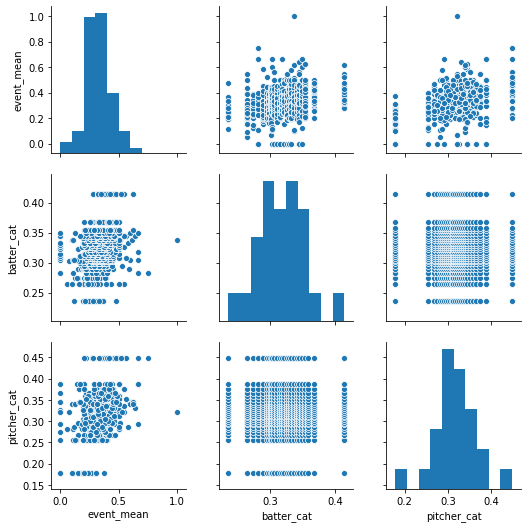

<IPython.core.display.Javascript object>

In [1116]:
# f, ax1 = plt.subplots()
sns.pairplot(df_sc_events4model_bp_pbin_bbin_LB_LP_agg_4model)

#### Linear regression

In [1117]:
# Drop rows with na in target - just leave out of model
df_sc_events4model_bp_pbin_bbin_LB_LP_agg_4model.dropna(inplace=True)

<IPython.core.display.Javascript object>

In [1118]:
feature_list = ["batter_cat", "pitcher_cat"]
target_col = "event_mean"

(
    X_train_scale_d_LL,
    X_test_scale_d_LL,
    y_train_d_LL,
    y_test_d_LL,
    scaler_d_LL,
) = get_split_data(
    df_sc_events4model_bp_pbin_bbin_LB_LP_agg_4model[feature_list],
    df_sc_events4model_bp_pbin_bbin_LB_LP_agg_4model[target_col],
    0.4,
)

<IPython.core.display.Javascript object>

In [1098]:
# df_sc_events4model_bp_pbin_bbin_LB_LP_agg_4model.isna().sum()

<IPython.core.display.Javascript object>

In [1119]:
df_sc_events4model_bp_pbin_bbin_LB_LP_agg_4model.shape

(582, 3)

<IPython.core.display.Javascript object>

In [1120]:
lin_reg_LL_v0, df_eval_LL_v0 = run_linreg_model(
    X_train_scale_d_LL, y_train_d_LL, X_test_scale_d_LL, y_test_d_LL
)

<IPython.core.display.Javascript object>

In [1121]:
df_eval_LL_v0

,test,pred
594,0.403846,0.386584
447,0.368421,0.376376
495,0.450000,0.371301
151,0.259542,0.252937
38,0.545455,0.270913
...,...,...
48,0.500000,0.320021
157,0.252632,0.284187
13,0.222222,0.244957
351,0.250000,0.277071


<IPython.core.display.Javascript object>

In [1122]:
metrics.r2_score(df_eval_LL_v0["test"], df_eval_LL_v0["pred"])

0.23836675150006947

<IPython.core.display.Javascript object>

### Left-handed batter, right-handed pitcher

In [1178]:
df_sc_events4model_bp_pbin_bbin_LB_RP.shape

(140603, 37)

<IPython.core.display.Javascript object>

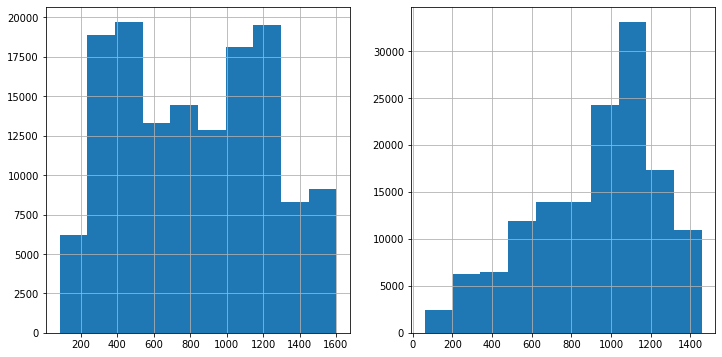

<IPython.core.display.Javascript object>

In [1179]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
df_sc_events4model_bp_pbin_bbin_LB_RP["stand_counts_0"].hist(ax=ax1)
df_sc_events4model_bp_pbin_bbin_LB_RP["p_throws_counts_1"].hist(ax=ax2)

In [1180]:
df_sc_events4model_bp_pbin_bbin_LB_RP.head()

,game_date,batter,pitcher,events,stand,p_throws,inning_topbot,WAR_x,OBP,SLG,...,p_throws_prop_1,stand_counts_0,stand_counts_1,stand_prop_0,stand_prop_1,p_throws_prop_0_cat,p_throws_prop_1_cat,stand_prop_0_cat,stand_prop_1_cat,BH0_obp_vs_PH1
0,2015-10-04,547180.0,544727.0,double,0,1,0,3.4,0.393,0.496,...,0.385156,444,499,0.36036,0.306613,"(0.355, 0.362]","(0.373, 0.412]","(0.356, 0.361]","(0.305, 0.307]",0.385156
1,2015-09-08,547180.0,544727.0,walk,0,1,1,3.4,0.393,0.496,...,0.385156,444,499,0.36036,0.306613,"(0.355, 0.362]","(0.373, 0.412]","(0.356, 0.361]","(0.305, 0.307]",0.385156
2,2015-09-07,547180.0,544727.0,strikeout,0,1,1,3.4,0.393,0.496,...,0.385156,444,499,0.36036,0.306613,"(0.355, 0.362]","(0.373, 0.412]","(0.356, 0.361]","(0.305, 0.307]",0.385156
3,2015-07-21,547180.0,544727.0,hit_by_pitch,0,1,1,3.4,0.393,0.496,...,0.385156,444,499,0.36036,0.306613,"(0.355, 0.362]","(0.373, 0.412]","(0.356, 0.361]","(0.305, 0.307]",0.385156
4,2015-05-03,547180.0,544727.0,strikeout,0,1,0,3.4,0.393,0.496,...,0.385156,444,499,0.36036,0.306613,"(0.355, 0.362]","(0.373, 0.412]","(0.356, 0.361]","(0.305, 0.307]",0.385156


<IPython.core.display.Javascript object>

In [1181]:
# Get the proportion from each category combination with groupby
df_sc_events4model_bp_pbin_bbin_LB_RP_agg = df_sc_events4model_bp_pbin_bbin_LB_RP.groupby(['stand_prop_0_cat', 'p_throws_prop_1_cat'])['event_code'].mean()


<IPython.core.display.Javascript object>

In [1182]:
bat_cat_mp_LR = pd.Series(
    df_sc_events4model_bp_pbin_bbin_LB_RP_agg.index.get_level_values(0).tolist()
).apply(lambda x: x.mid)

pitch_cat_mp_LR = pd.Series(
    df_sc_events4model_bp_pbin_bbin_LB_RP_agg.index.get_level_values(1).tolist()
).apply(lambda x: x.mid)
df_sc_events4model_bp_pbin_bbin_LB_RP_agg_4model = pd.DataFrame(
    {
        "event_mean": df_sc_events4model_bp_pbin_bbin_LB_RP_agg.tolist(),
        "batter_cat": bat_cat_mp_LR,
        "pitcher_cat": pitch_cat_mp_LR,
    }
)

<IPython.core.display.Javascript object>

In [1183]:
df_sc_events4model_bp_pbin_bbin_LB_RP.columns

Index(['game_date', 'batter', 'pitcher', 'events', 'stand', 'p_throws',
       'inning_topbot', 'WAR_x', 'OBP', 'SLG', 'OPS', 'BB_perc', 'K_perc',
       'key_mlbam_x', 'WAR_y', 'WHIP', 'ERA', 'BB/9', 'K/9', 'HR/9',
       'key_mlbam_y', 'event_code', 'OBP_cat', 'WHIP_cat', 'p_throws_counts_0',
       'p_throws_counts_1', 'p_throws_prop_0', 'p_throws_prop_1',
       'stand_counts_0', 'stand_counts_1', 'stand_prop_0', 'stand_prop_1',
       'p_throws_prop_0_cat', 'p_throws_prop_1_cat', 'stand_prop_0_cat',
       'stand_prop_1_cat', 'BH0_obp_vs_PH1'],
      dtype='object')

<IPython.core.display.Javascript object>

In [1184]:
df_sc_events4model_bp_pbin_bbin_LB_RP_agg_4model.shape

(625, 3)

<IPython.core.display.Javascript object>

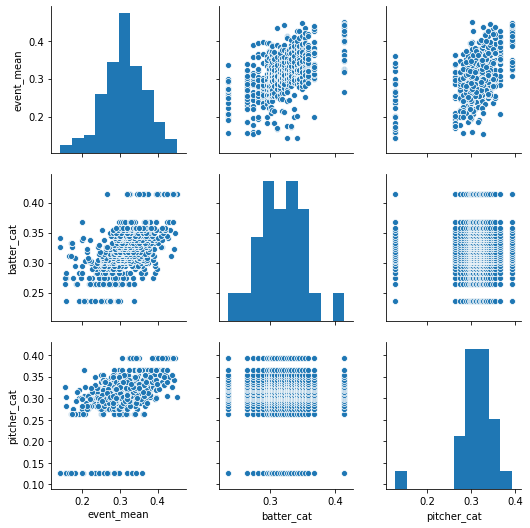

<IPython.core.display.Javascript object>

In [1185]:
sns.pairplot(df_sc_events4model_bp_pbin_bbin_LB_RP_agg_4model)

#### Linear regression

In [1186]:
feature_list = ["batter_cat", "pitcher_cat"]
target_col = "event_mean"

(
    X_train_scale_d_LR,
    X_test_scale_d_LR,
    y_train_d_LR,
    y_test_d_LR,
    scaler_d_LR,
) = get_split_data(
    df_sc_events4model_bp_pbin_bbin_LB_RP_agg_4model[feature_list],
    df_sc_events4model_bp_pbin_bbin_LB_RP_agg_4model[target_col],
    0.4,
)

<IPython.core.display.Javascript object>

In [1187]:
lin_reg_LR_v0, df_eval_LR_v0 = run_linreg_model(
    X_train_scale_d_LR, y_train_d_LR, X_test_scale_d_LR, y_test_d_LR
)

<IPython.core.display.Javascript object>

In [1188]:
df_eval_LR_v0.head()

,test,pred
574,0.412351,0.390363
601,0.362500,0.363992
104,0.253086,0.276535
278,0.257732,0.294342
261,0.303571,0.307369


<IPython.core.display.Javascript object>

In [1189]:
metrics.r2_score(df_eval_LR_v0["test"], df_eval_LR_v0["pred"])

0.5614334664393534

<IPython.core.display.Javascript object>

### RH batter, LH pitcher

In [1202]:
df_sc_events4model_bp_pbin_bbin_RB_LP.shape

(85516, 37)

<IPython.core.display.Javascript object>

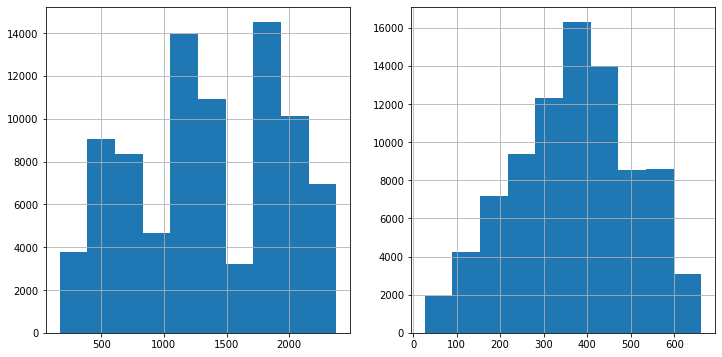

<IPython.core.display.Javascript object>

In [1199]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
df_sc_events4model_bp_pbin_bbin_RB_LP["stand_counts_1"].hist(ax=ax1)
df_sc_events4model_bp_pbin_bbin_RB_LP["p_throws_counts_0"].hist(ax=ax2)

In [1203]:
# Get the proportion from each category combination with groupby
df_sc_events4model_bp_pbin_bbin_RB_LP_agg = df_sc_events4model_bp_pbin_bbin_RB_LP.groupby(['stand_prop_1_cat', 'p_throws_prop_0_cat'])['event_code'].mean()


<IPython.core.display.Javascript object>

In [1204]:
bat_cat_mp_RL = pd.Series(
    df_sc_events4model_bp_pbin_bbin_RB_LP_agg.index.get_level_values(0).tolist()
).apply(lambda x: x.mid)

pitch_cat_mp_RL = pd.Series(
    df_sc_events4model_bp_pbin_bbin_RB_LP_agg.index.get_level_values(1).tolist()
).apply(lambda x: x.mid)
df_sc_events4model_bp_pbin_bbin_RB_LP_agg_4model = pd.DataFrame(
    {
        "event_mean": df_sc_events4model_bp_pbin_bbin_RB_LP_agg.tolist(),
        "batter_cat": bat_cat_mp_RL,
        "pitcher_cat": pitch_cat_mp_RL,
    }
)

<IPython.core.display.Javascript object>

/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


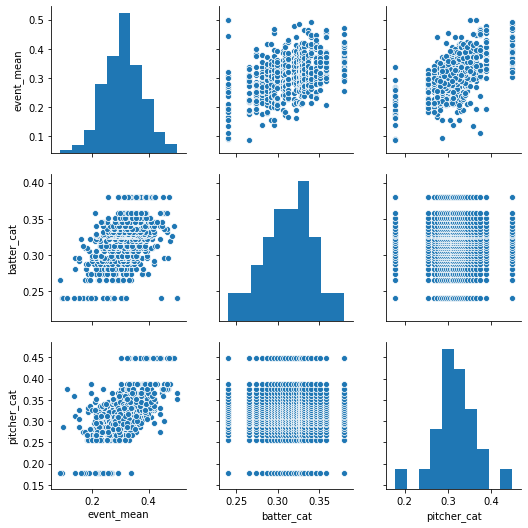

<IPython.core.display.Javascript object>

In [1205]:
sns.pairplot(df_sc_events4model_bp_pbin_bbin_RB_LP_agg_4model)

#### Linear regression

In [1206]:
# Drop rows with na in target - just leave out of model
df_sc_events4model_bp_pbin_bbin_RB_LP_agg_4model.dropna(inplace=True)

<IPython.core.display.Javascript object>

In [1207]:
feature_list = ["batter_cat", "pitcher_cat"]
target_col = "event_mean"

(
    X_train_scale_d_RL,
    X_test_scale_d_RL,
    y_train_d_RL,
    y_test_d_RL,
    scaler_d_RL,
) = get_split_data(
    df_sc_events4model_bp_pbin_bbin_RB_LP_agg_4model[feature_list],
    df_sc_events4model_bp_pbin_bbin_RB_LP_agg_4model[target_col],
    0.4,
)

<IPython.core.display.Javascript object>

In [1208]:
lin_reg_RL_v0, df_eval_RL_v0 = run_linreg_model(
    X_train_scale_d_RL, y_train_d_RL, X_test_scale_d_RL, y_test_d_RL
)

<IPython.core.display.Javascript object>

In [1209]:
metrics.r2_score(df_eval_RL_v0["test"], df_eval_RL_v0["pred"])

0.5857688766257165

<IPython.core.display.Javascript object>

### RH batter, RH pitcher

In [1211]:
df_sc_events4model_bp_pbin_bbin_RB_RP.shape

(155968, 37)

<IPython.core.display.Javascript object>

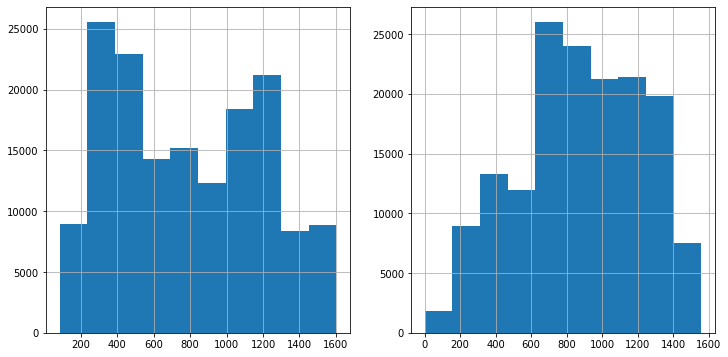

<IPython.core.display.Javascript object>

In [1210]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
df_sc_events4model_bp_pbin_bbin_RB_RP["stand_counts_0"].hist(ax=ax1)

df_sc_events4model_bp_pbin_bbin_RB_RP["p_throws_counts_1"].hist(ax=ax2)

In [1212]:
# Get the proportion from each category combination with groupby
df_sc_events4model_bp_pbin_bbin_RB_RP_agg = df_sc_events4model_bp_pbin_bbin_RB_RP.groupby(['stand_prop_1_cat', 'p_throws_prop_1_cat'])['event_code'].mean()


<IPython.core.display.Javascript object>

In [1213]:
bat_cat_mp_RR = pd.Series(
    df_sc_events4model_bp_pbin_bbin_RB_RP_agg.index.get_level_values(0).tolist()
).apply(lambda x: x.mid)

pitch_cat_mp_RR = pd.Series(
    df_sc_events4model_bp_pbin_bbin_RB_RP_agg.index.get_level_values(1).tolist()
).apply(lambda x: x.mid)
df_sc_events4model_bp_pbin_bbin_RB_RP_agg_4model = pd.DataFrame(
    {
        "event_mean": df_sc_events4model_bp_pbin_bbin_RB_RP_agg.tolist(),
        "batter_cat": bat_cat_mp_RR,
        "pitcher_cat": pitch_cat_mp_RR,
    }
)

<IPython.core.display.Javascript object>

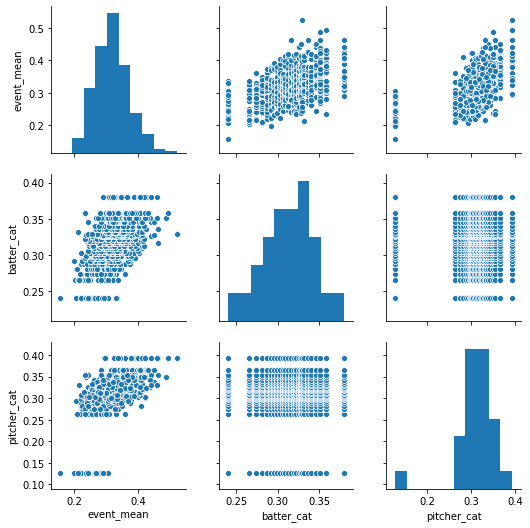

<IPython.core.display.Javascript object>

In [1214]:
sns.pairplot(df_sc_events4model_bp_pbin_bbin_RB_RP_agg_4model)

#### Linear regression

In [1215]:
feature_list = ["batter_cat", "pitcher_cat"]
target_col = "event_mean"

(
    X_train_scale_d_RR,
    X_test_scale_d_RR,
    y_train_d_RR,
    y_test_d_RR,
    scaler_d_RR,
) = get_split_data(
    df_sc_events4model_bp_pbin_bbin_RB_RP_agg_4model[feature_list],
    df_sc_events4model_bp_pbin_bbin_RB_RP_agg_4model[target_col],
    0.4,
)

<IPython.core.display.Javascript object>

In [1216]:
lin_reg_RR_v0, df_eval_RR_v0 = run_linreg_model(
    X_train_scale_d_RR, y_train_d_RR, X_test_scale_d_RR, y_test_d_RR
)

<IPython.core.display.Javascript object>

In [1217]:
metrics.r2_score(df_eval_RR_v0["test"], df_eval_RR_v0["pred"])

0.5891988510906061

<IPython.core.display.Javascript object>

## Notes below

In [ ]:
# Get the proportion from each category combination with groupby
df_sc_events4model_bp_agg = df_sc_events4model_bp.groupby(["OBP_cat", "WHIP_cat"])[
    "event_code"
].mean()

In [ ]:
# # Get the proportion from each category combination with groupby
# df_sc_events4model_bp_agg = df_sc_events4model_bp.groupby(["OBP_cat", "WHIP_cat"])[
#     "event_code"
# ].mean()

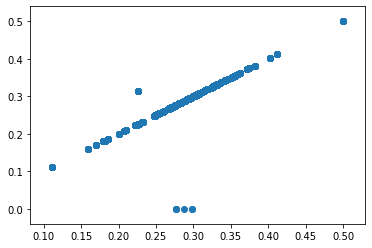

<IPython.core.display.Javascript object>

In [1067]:
f, ax1 = plt.subplots()

ax1.scatter(
    df_sc_events4model_bp_pbin_bbin_LB_LP["p_throws_prop_0"],
    df_sc_events4model_bp_pbin_bbin_LB_LP["BH0_obp_vs_PH0"],
)

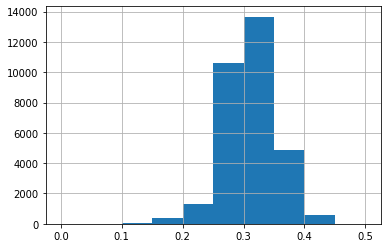

<IPython.core.display.Javascript object>

In [1062]:
df_sc_events4model_bp_pbin_bbin_LB_LP["BH0_obp_vs_PH0"].hist()

In [1044]:
s_LHB_LHP_prop = df_sc_events4model_bp_pbin_bbin_LB_LP.groupby("batter").mean()[
    "event_code"
]
s_LHB_RHP_prop = df_sc_events4model_bp_pbin_bbin_LB_RP.groupby("batter").mean()[
    "event_code"
]
s_RHB_LHP_prop = df_sc_events4model_bp_pbin_bbin_RB_LP.groupby("batter").mean()[
    "event_code"
]
s_RHB_RHP_prop = df_sc_events4model_bp_pbin_bbin_RB_RP.groupby("batter").mean()[
    "event_code"
]

<IPython.core.display.Javascript object>

In [ ]:
# New dataframe and filter event code based on L/R matchup

In [1054]:
df_temp = pd.merge(
    df_sc_events4model_bp_pbin_bbin, s_LHB_LHP_prop, left_on="batter", right_index=True
)

<IPython.core.display.Javascript object>

In [1055]:
df_temp.head()

,game_date,batter,pitcher,events,stand,p_throws,inning_topbot,WAR_x,OBP,SLG,...,p_throws_prop_1,stand_counts_0,stand_counts_1,stand_prop_0,stand_prop_1,p_throws_prop_0_cat,p_throws_prop_1_cat,stand_prop_0_cat,stand_prop_1_cat,LHB_obp_vs_LHP
0,2015-10-04,547180.0,544727.0,double,0,1,0,3.4,0.393,0.496,...,0.385156,444,499,0.36036,0.306613,"(0.355, 0.362]","(0.373, 0.412]","(0.356, 0.361]","(0.305, 0.307]",0.355102
1,2015-09-08,547180.0,544727.0,walk,0,1,1,3.4,0.393,0.496,...,0.385156,444,499,0.36036,0.306613,"(0.355, 0.362]","(0.373, 0.412]","(0.356, 0.361]","(0.305, 0.307]",0.355102
2,2015-09-07,547180.0,544727.0,strikeout,0,1,1,3.4,0.393,0.496,...,0.385156,444,499,0.36036,0.306613,"(0.355, 0.362]","(0.373, 0.412]","(0.356, 0.361]","(0.305, 0.307]",0.355102
3,2015-07-21,547180.0,544727.0,hit_by_pitch,0,1,1,3.4,0.393,0.496,...,0.385156,444,499,0.36036,0.306613,"(0.355, 0.362]","(0.373, 0.412]","(0.356, 0.361]","(0.305, 0.307]",0.355102
4,2015-05-03,547180.0,544727.0,strikeout,0,1,0,3.4,0.393,0.496,...,0.385156,444,499,0.36036,0.306613,"(0.355, 0.362]","(0.373, 0.412]","(0.356, 0.361]","(0.305, 0.307]",0.355102


<IPython.core.display.Javascript object>

In [ ]:
df_temp_LHB_RHP_sc = df_temp

In [1047]:
type(s_LHB_LHP_prop)

pandas.core.series.Series

<IPython.core.display.Javascript object>

In [1052]:
s_LHB_LHP_prop.name = "LHB_obp_vs_LHP"

<IPython.core.display.Javascript object>

In [1053]:
s_LHB_LHP_prop.head()

batter
400284.0    0.179487
408045.0    0.352480
408236.0    0.323383
425783.0    0.352814
429664.0    0.289608
Name: LHB_obp_vs_LHP, dtype: float64

<IPython.core.display.Javascript object>

In [ ]:
pd.merge()

In [1038]:
def assign_categories_by_qcut(df, list_of_col2bin, no_bins, no2split):

    for col in list_of_col2bin:
        colname = col + "_cat"
        print(col)
        df[colname] = pd.qcut(df[col], 25, duplicates="drop")

        print("No. of categories: ", len(df[colname].unique()))

    # No. of category combinations based on length of col2bin and no2split
    no_combo = 2

    list_first_half = list_of_col2bin[0:no_combo]
    list_second_half = list_of_col2bin[-no_combo:]

    df_agg_list = list()
    count = 0
    for p_throws_prop in list_first_half:
        for b_stand_prop in list_second_half:
            df_temp_bp_agg = df.groupby([p_throws_prop, b_stand_prop])[
                "event_code"
            ].mean()
            df_agg_list.append(df_temp_bp_agg)

            count += 1

            print(p_throws_prop, b_stand_prop)

    return df_agg_list

<IPython.core.display.Javascript object>

In [1039]:
mycol2bin = ["p_throws_prop_0", "p_throws_prop_1", "stand_prop_0", "stand_prop_1"]
# df_sc_events4model_bp_pbin_bbin_wcat =

df_agg_list_temp = assign_categories_by_qcut(
    df_sc_events4model_bp_pbin_bbin, mycol2bin, 25, 2
)

p_throws_prop_0
No. of categories:  26
p_throws_prop_1
No. of categories:  25
stand_prop_0
No. of categories:  25
stand_prop_1
No. of categories:  25
p_throws_prop_0 stand_prop_0
p_throws_prop_0 stand_prop_1
p_throws_prop_1 stand_prop_0
p_throws_prop_1 stand_prop_1


<IPython.core.display.Javascript object>

In [1040]:
df_agg_list_temp

[p_throws_prop_0  stand_prop_0
 0.111111         0.214912        0.000000
                  0.241573        0.000000
                  0.252983        1.000000
                  0.254346        0.000000
                  0.256131        0.000000
                                    ...   
 0.500000         0.372549        1.000000
                  0.380165        0.500000
                  0.387097        1.000000
                  0.397163        0.333333
                  0.397727        0.500000
 Name: event_code, Length: 76038, dtype: float64, p_throws_prop_0  stand_prop_1
 0.111111         0.225974        0.000000
                  0.238095        0.000000
                  0.245845        0.500000
                  0.245902        1.000000
                  0.250373        1.000000
                                    ...   
 0.500000         0.356347        0.500000
                  0.369198        0.333333
                  0.371560        1.000000
                  0.373239   

<IPython.core.display.Javascript object>

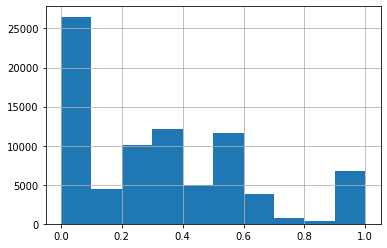

<IPython.core.display.Javascript object>

In [1026]:
df_agg_list_temp.hist()

In [1015]:
df_agg_list_temp.index

MultiIndex([(                0.0,  0.3196223870532704),
            (0.16279069767441862,  0.2224622030237581),
            (0.16279069767441862, 0.23809523809523808),
            (0.16279069767441862,  0.2471169686985173),
            (0.16279069767441862, 0.24778761061946902),
            (0.16279069767441862,  0.2503725782414307),
            (0.16279069767441862, 0.25443786982248523),
            (0.16279069767441862, 0.25914634146341464),
            (0.16279069767441862,  0.2612244897959184),
            (0.16279069767441862, 0.26296296296296295),
            ...
            ( 0.4121996303142329, 0.36939313984168864),
            ( 0.4121996303142329,  0.3732394366197183),
            ( 0.4121996303142329, 0.37448559670781895),
            ( 0.4121996303142329,   0.375886524822695),
            ( 0.4121996303142329, 0.37719298245614036),
            ( 0.4121996303142329, 0.37808807733619765),
            ( 0.4121996303142329,  0.3789329685362517),
            ( 0.4121996303142329

<IPython.core.display.Javascript object>

In [1023]:
pd.Series(df_agg_list_temp.index.get_level_values(0))

0        0.000000
1        0.162791
2        0.162791
3        0.162791
4        0.162791
           ...   
81399    0.412200
81400    0.412200
81401    0.412200
81402    0.412200
81403    0.412200
Name: p_throws_prop_1, Length: 81404, dtype: float64

<IPython.core.display.Javascript object>

In [1024]:
pd.Series(df_agg_list_temp.index.get_level_values(1))

0        0.319622
1        0.222462
2        0.238095
3        0.247117
4        0.247788
           ...   
81399    0.378088
81400    0.378933
81401    0.384615
81402    0.389222
81403    0.396450
Name: stand_prop_1, Length: 81404, dtype: float64

<IPython.core.display.Javascript object>

In [1018]:
cat_bp = pd.Series(df_agg_list_temp.index.get_level_values(1).tolist()).apply(
    lambda x: x.left
)

AttributeError: 'float' object has no attribute 'left'

<IPython.core.display.Javascript object>

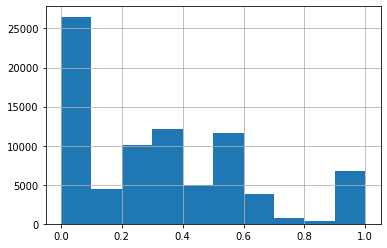

<IPython.core.display.Javascript object>

In [1014]:
df_agg_list_temp.hist()

In [990]:
df_temp = df_sc_events4model_bp_pbin_bbin.copy()

<IPython.core.display.Javascript object>

In [991]:
df_temp.shape

(413566, 32)

<IPython.core.display.Javascript object>

In [992]:
s_temp_qcut = pd.qcut(df_temp["stand_prop_0"], 25, duplicates="drop")

<IPython.core.display.Javascript object>

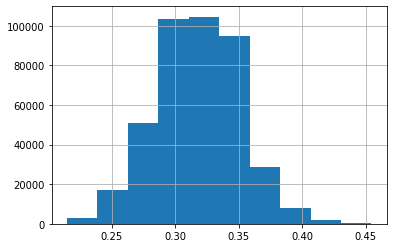

<IPython.core.display.Javascript object>

In [993]:
df_temp["stand_prop_0"].hist()

In [996]:
len(s_temp_qcut.value_counts())

25

<IPython.core.display.Javascript object>

In [995]:
s_temp_qcut

0         (0.356, 0.361]
1         (0.356, 0.361]
2         (0.356, 0.361]
3         (0.356, 0.361]
4         (0.356, 0.361]
               ...      
413522    (0.286, 0.292]
413523    (0.286, 0.292]
413524    (0.286, 0.292]
413490    (0.286, 0.292]
413491    (0.286, 0.292]
Name: stand_prop_0, Length: 413566, dtype: category
Categories (25, interval[float64]): [(0.214, 0.258] < (0.258, 0.271] < (0.271, 0.278] < (0.278, 0.286] ... (0.352, 0.356] < (0.356, 0.361] < (0.361, 0.373] < (0.373, 0.455]]

<IPython.core.display.Javascript object>

In [ ]:
# Bin these so that the most frequent categories are subdivided more
df_sc_events4model_bp["OBP_cat"] = pd.qcut(df_sc_events4model_bp["OBP"], 25)
df_sc_events4model_bp["WHIP_cat"] = pd.qcut(df_sc_events4model_bp["WHIP"], 25)


# Get the proportion from each category combination with groupby
df_sc_events4model_bp_agg = df_sc_events4model_bp.groupby(["OBP_cat", "WHIP_cat"])[
    "event_code"
].mean()


bat_cat_mp = pd.Series(
    df_sc_events4model_bp_agg.index.get_level_values(0).tolist()
).apply(lambda x: x.mid)
pitch_cat_mp = pd.Series(
    df_sc_events4model_bp_agg.index.get_level_values(1).tolist()
).apply(lambda x: x.mid)

df_sc_events4model_bp_agg_4model = pd.DataFrame(
    {
        "event_mean": df_sc_events4model_bp_agg.tolist(),
        "batter_cat": bat_cat_mp,
        "pitcher_cat": pitch_cat_mp,
    }
)

In [ ]:
bat_cat_mp_4_bin = (
    pd.Series(df_sc_events4model_bp_agg.index.get_level_values(0).tolist())
    .apply(lambda x: x.left)
    .unique()
)

bat_cat_mp_4_bin_r = (
    pd.Series(df_sc_events4model_bp_agg.index.get_level_values(0).tolist())
    .apply(lambda x: x.right)
    .unique()
)
all_bin_sep = bat_cat_mp_4_bin.tolist() + bat_cat_mp_4_bin_r.tolist()

# Notes

## Calculating prediction uncertainty - one feature


In [372]:
df_sc_events4model_bp_agg_4model.head()

,event_mean,batter_cat,pitcher_cat
0,0.221154,0.2105,0.8495
1,0.263848,0.2105,0.9500
2,0.269930,0.2105,1.0150
3,0.271264,0.2105,1.0600
4,0.268595,0.2105,1.0900


<IPython.core.display.Javascript object>

In [349]:
df_temp = df_sc_events4model_bp_agg_4model.iloc[0:100, :].copy()

<IPython.core.display.Javascript object>

In [ ]:
# Try a non-standard scaled model with just batter category

In [361]:
def get_split_data_noscale(X, y, testsize):

    if len(X.shape) > 1:
        # Split data between train and test_and_holdout
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=testsize, random_state=19
        )
        print("use brackets")

    else:
        # Split data between train and test_and_holdout
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=testsize, random_state=19
        )

    return X_train, X_test, y_train, y_test

<IPython.core.display.Javascript object>

In [362]:
df_temp.head()

,event_mean,batter_cat,pitcher_cat
0,0.221154,0.2105,0.8495
1,0.263848,0.2105,0.9500
2,0.269930,0.2105,1.0150
3,0.271264,0.2105,1.0600
4,0.268595,0.2105,1.0900


<IPython.core.display.Javascript object>

In [373]:
(
    X_train_noscale,
    X_test_noscale,
    y_train_noscale,
    y_test_noscale,
) = get_split_data_noscale(
    df_sc_events4model_bp_agg_4model[["batter_cat"]],
    df_sc_events4model_bp_agg_4model["event_mean"],
    0.4,
)

use brackets


<IPython.core.display.Javascript object>

In [374]:
def run_linreg_model_1var(X_train_scale_set, y_train_set, X_test_scale_set, y_test_set):

    lin_reg = LinearRegression()
    lin_reg.fit(X_train_scale_set, y_train_set)

    y_pred = lin_reg.predict(X_test_scale_set)
    df_eval = pd.DataFrame({"test": y_test_set, "pred": y_pred})

    return lin_reg, df_eval

<IPython.core.display.Javascript object>

In [375]:
lin_reg_noscale, df_eval_noscale = run_linreg_model_1var(
    X_train_noscale, y_train_noscale, X_test_noscale, y_test_noscale
)

<IPython.core.display.Javascript object>

In [376]:
df_eval_noscale

,test,pred
574,0.337190,0.343184
601,0.363770,0.371353
104,0.244851,0.301059
278,0.312102,0.316565
261,0.309453,0.314497
...,...,...
419,0.312139,0.325610
414,0.338759,0.325610
542,0.382090,0.339049
333,0.333676,0.319408


<IPython.core.display.Javascript object>

In [493]:
X_train_noscale

,batter_cat
483,0.3540
288,0.3210
302,0.3240
193,0.3065
385,0.3340
...,...
308,0.3240
19,0.2105
354,0.3300
622,0.4270


<IPython.core.display.Javascript object>

Text(0, 0.5, 'event_mean')

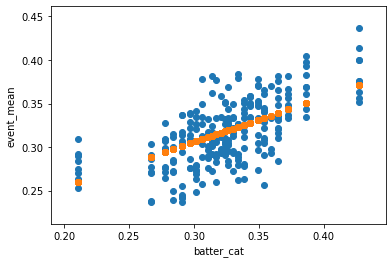

<IPython.core.display.Javascript object>

In [377]:
f, ax1 = plt.subplots()
ax1.scatter(
    X_test_noscale, y_test_noscale,
)
ax1.scatter(
    X_test_noscale, df_eval_noscale["pred"],
)
ax1.set_xlabel("batter_cat")
ax1.set_ylabel("event_mean")

In [378]:
lin_reg_v0.coef_

array([0.02276625, 0.01623917])

<IPython.core.display.Javascript object>

In [ ]:
#https://machinelearningmastery.com/prediction-intervals-for-machine-learning/
# yhat +/- z * sigma

In [ ]:
# http://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLSResults.get_prediction.html

#OLSResults.get_prediction(exog=None, transform=True, weights=None, row_labels=None, **kwargs)¶


In [380]:
#from statsmodels.regression.linear_model import OLSResults

<IPython.core.display.Javascript object>

In [710]:
X_train4now = X_train_noscale[0:50]
y_train4now = y_train_noscale[0:50]

<IPython.core.display.Javascript object>

In [714]:
y_train4now

483    0.325770
288    0.328542
302    0.287145
193    0.332436
385    0.301980
103    0.291583
564    0.383285
216    0.303502
567    0.366313
262    0.327899
323    0.337818
6      0.269956
400    0.258197
599    0.417936
84     0.293065
391    0.314159
102    0.221929
503    0.296768
145    0.315051
30     0.245997
570    0.346314
562    0.385675
356    0.304410
36     0.296909
89     0.292994
190    0.358079
351    0.286041
619    0.382696
141    0.311355
237    0.288462
130    0.289683
295    0.360390
511    0.362652
8      0.280720
210    0.294416
118    0.316156
404    0.322476
518    0.376947
431    0.330508
522    0.366071
196    0.301695
424    0.348185
28     0.283272
48     0.283871
13     0.267857
587    0.411924
264    0.314185
181    0.327243
350    0.281289
593    0.392606
Name: event_mean, dtype: float64

<IPython.core.display.Javascript object>

## Prediction interval function

In [804]:
def get_prediction_se_obs(X_train, y_train):

    # Construct dataframe for use in statsmodels
    X_train = sm.add_constant(X_train)
    df4sm_ci = pd.concat([X_train, y_train], axis=1)

    # Reset index names and column headers
    df4sm_ci.columns = range(len(df4sm_ci.columns))
    df4sm_ci.reset_index(drop=True, inplace=True)

    # Make linear regression model
    linmodel = sm.OLS(df4sm_ci.iloc[:, -1], df_for_sm.iloc[:, :-1]).fit()
    linmodel_pred_results = linmodel.get_prediction(df4sm_ci.iloc[:, -1])

    pred_vals = linmodel_pred_results.predicted_mean
    se_obs_of_model = linmodel_func_pred_results.se_obs

    # (pred_vals, pred_vals - se_obs_of_model, pred_vals + se_obs_of_model)

    return se_obs_of_model

<IPython.core.display.Javascript object>

In [805]:
get_prediction_se_obs(X_train4now, y_train4now)

array([0.03255721, 0.0324893 , 0.03249521, 0.03246152, 0.03251528,
       0.03243322, 0.03259812, 0.03247001, 0.03259812, 0.03248151,
       0.03249521, 0.03230956, 0.03252451, 0.03262925, 0.03242091,
       0.03251528, 0.03243322, 0.03256807, 0.032444  , 0.03239225,
       0.03259812, 0.03259812, 0.03250718, 0.03239225, 0.03242091,
       0.03246152, 0.03250718, 0.03273039, 0.032444  , 0.03247573,
       0.032444  , 0.0324893 , 0.03256807, 0.03230956, 0.03247001,
       0.03243322, 0.03252451, 0.03256807, 0.0325349 , 0.03256807,
       0.03246152, 0.03252451, 0.03239225, 0.03239225, 0.03230956,
       0.03262925, 0.03248151, 0.03246152, 0.03250718, 0.03262925])

<IPython.core.display.Javascript object>

In [755]:
lin_model_func.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      2   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                              4974.
Date:                Mon, 03 Feb 2020   Prob (F-statistic):                    6.20e-51
Time:                        19:59:55   Log-Likelihood:                          101.39
No. Observations:                  50   AIC:                                     -200.8
Df Residuals:                      49   BIC:                                     -198.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
batter_cat     0.9932      0.014     70.528      0.000       0.965       1.022
==============================================================================
Omnibus:                        0.987   Durbin-Watson:                   2.250
Prob(Omnibus):                  0.610   Jarque-Bera (JB):                0.617
Skew:                          -0.271   Prob(JB):                        0.735
Kurtosis:                       3.044   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [756]:
linmodel_func_pred_results = lin_model_func.get_prediction(X_train4now)

<IPython.core.display.Javascript object>

In [759]:
linmodel_func_pred_results.conf_int()

array([[0.34157552, 0.36161163],
       [0.30973373, 0.32790207],
       [0.31262844, 0.33096658],
       [0.29574265, 0.3130903 ],
       [0.32227747, 0.3411816 ],
       [0.28078666, 0.29725702],
       [0.35942622, 0.38050941],
       [0.30008471, 0.31768705],
       [0.35942622, 0.38050941],
       [0.30587412, 0.32381607],
       [0.31262844, 0.33096658],
       [0.203112  , 0.21502613],
       [0.32661953, 0.34577835],
       [0.3724524 , 0.39429969],
       [0.27403234, 0.29010651],
       [0.32227747, 0.3411816 ],
       [0.28078666, 0.29725702],
       [0.34640003, 0.36671914],
       [0.28657607, 0.30338603],
       [0.25762899, 0.27274098],
       [0.35942622, 0.38050941],
       [0.35942622, 0.38050941],
       [0.31841786, 0.33709559],
       [0.25762899, 0.27274098],
       [0.27403234, 0.29010651],
       [0.29574265, 0.3130903 ],
       [0.31841786, 0.33709559],
       [0.41201341, 0.43618126],
       [0.28657607, 0.30338603],
       [0.30297942, 0.32075156],
       [0.

<IPython.core.display.Javascript object>

In [793]:
linmodel_func_pred_results.predicted_mean - linmodel_func_pred_results.se_obs

array([0.31903636, 0.2863286 , 0.2893023 , 0.27195495, 0.29921425,
       0.25658862, 0.3373697 , 0.27641587, 0.3373697 , 0.28236358,
       0.2893023 , 0.1767595 , 0.30367444, 0.35074679, 0.24964851,
       0.29921425, 0.25658862, 0.32399152, 0.26253705, 0.23279274,
       0.3373697 , 0.3373697 , 0.29524955, 0.23279274, 0.24964851,
       0.27195495, 0.29524955, 0.39136694, 0.26253705, 0.27938976,
       0.26253705, 0.2863286 , 0.32399152, 0.1767595 , 0.27641587,
       0.25658862, 0.30367444, 0.32399152, 0.30863005, 0.32399152,
       0.27195495, 0.30367444, 0.23279274, 0.23279274, 0.1767595 ,
       0.35074679, 0.28236358, 0.27195495, 0.29524955, 0.35074679])

<IPython.core.display.Javascript object>

In [775]:
X_train4now.shape

(50, 1)

<IPython.core.display.Javascript object>

In [790]:
df_temp = pd.concat(
    [
        pd.Series(y_train4now.values),
        pd.Series(linmodel_func_pred_results.predicted_mean),
        pd.Series(linmodel_func_pred_results.se_obs),
        pd.DataFrame(linmodel_func_pred_results.conf_int()),
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

In [720]:
# Construct dataframe for use in statsmodels
df_for_sm = pd.concat([X_train4now, y_train4now], axis=1)
df_for_sm.reset_index(drop=True, inplace=True)
df_for_sm.head()

,batter_cat,event_mean
0,0.3540,0.325770
1,0.3210,0.328542
2,0.3240,0.287145
3,0.3065,0.332436
4,0.3340,0.301980


<IPython.core.display.Javascript object>

In [719]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

linmodel = ols("event_mean ~ batter_cat", df_for_sm).fit()
linmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             event_mean   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     55.48
Date:                Mon, 03 Feb 2020   Prob (F-statistic):           1.51e-09
Time:                        19:49:27   Log-Likelihood:                 106.37
No. Observations:                  50   AIC:                            -208.7
Df Residuals:                      48   BIC:                            -204.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0978      0.030      3.254      0.002       0.037       0.158
batter_cat     0.6933      0.093      7.449      0.000       0.506       0.880
==============================================================================
Omnibus:                        3.729   Durbin-Watson:                   2.370
Prob(Omnibus):                  0.155   Jarque-Bera (JB):                2.903
Skew:                          -0.579   Prob(JB):                        0.234
Kurtosis:                       3.225   Cond. No.                         24.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [507]:
linmodel_pred_results = linmodel.get_prediction(X_train4now)

<IPython.core.display.Javascript object>

In [508]:
X_train4now.head()

,batter_cat
483,0.3540
288,0.3210
302,0.3240
193,0.3065
385,0.3340


<IPython.core.display.Javascript object>

In [546]:
linmodel.get_prediction(pd.DataFrame({"batter_cat": [0.1, 0.354]})).predicted_mean

array([0.16717327, 0.34326672])

<IPython.core.display.Javascript object>

In [551]:
linmodel.get_prediction(pd.DataFrame({"batter_cat": [0.1, 0.354]})).conf_int()

array([[0.12516385, 0.20918268],
       [0.33275463, 0.35377881]])

<IPython.core.display.Javascript object>

In [549]:
linmodel.get_prediction(pd.DataFrame({"batter_cat": [0.1, 0.354]})).se_obs

array([0.03608714, 0.02988434])

<IPython.core.display.Javascript object>

In [510]:
df_temp = pd.concat(
    [
        df_for_sm,
        pd.Series(linmodel_pred_results.predicted_mean),
        pd.DataFrame(linmodel_pred_results.conf_int()),
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

In [436]:
df_temp.head(10)

,batter_cat,event_mean,0,0,1
0,0.3540,0.325770,0.333622,0.330344,0.336899
1,0.3210,0.328542,0.316565,0.313844,0.319285
2,0.3240,0.287145,0.318115,0.315404,0.320827
3,0.3065,0.332436,0.309070,0.306131,0.312009
4,0.3340,0.301980,0.323284,0.320510,0.326058
5,0.2910,0.291583,0.301059,0.297626,0.304492
6,0.3725,0.383285,0.343184,0.339140,0.347228
7,0.3110,0.303502,0.311396,0.308554,0.314238
8,0.3725,0.366313,0.343184,0.339140,0.347228
9,0.3170,0.327899,0.314497,0.311745,0.317250


<IPython.core.display.Javascript object>

In [511]:
linmodel_pred_results.var_resid

0.0008657391186062785

<IPython.core.display.Javascript object>

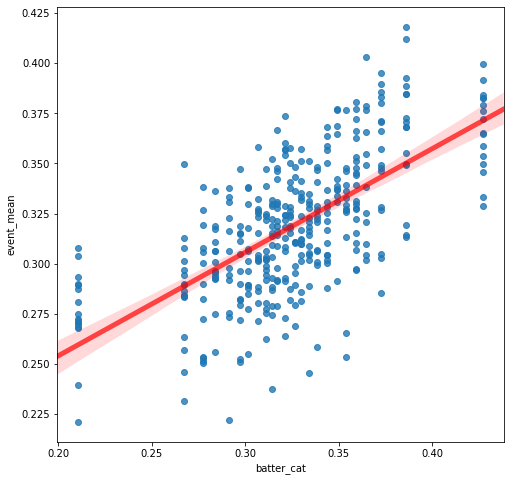

<IPython.core.display.Javascript object>

In [496]:
f, ax1 = plt.subplots(figsize=(8, 8))

sns.regplot(
    x=df_temp["batter_cat"],
    y=df_temp["event_mean"],
    line_kws={"color": "r", "alpha": 0.7, "lw": 5},
    ax=ax1,
)


In [513]:
df_temp.head()

,batter_cat,event_mean,0,0,1
0,0.3540,0.325770,0.343267,0.332755,0.353779
1,0.3210,0.328542,0.320388,0.312020,0.328757
2,0.3240,0.287145,0.322468,0.314068,0.330868
3,0.3065,0.332436,0.310336,0.301597,0.319075
4,0.3340,0.301980,0.329401,0.320633,0.338169


<IPython.core.display.Javascript object>

In [512]:
df_temp.shape

(50, 5)

<IPython.core.display.Javascript object>

In [514]:
linmodel_pred_results.var_pred_mean

array([2.73345517e-05, 1.73236190e-05, 1.74540766e-05, 1.88911894e-05,
       1.90150635e-05, 2.45949418e-05, 4.11999611e-05, 1.80148884e-05,
       4.11999611e-05, 1.73922262e-05, 1.74540766e-05, 1.21161643e-04,
       2.02827373e-05, 5.50601730e-05, 2.85351775e-05, 1.90150635e-05,
       2.45949418e-05, 3.04972393e-05, 2.18932738e-05, 4.16386313e-05,
       4.11999611e-05, 4.11999611e-05, 1.81827682e-05, 4.16386313e-05,
       2.85351775e-05, 1.88911894e-05, 1.81827682e-05, 1.16510560e-04,
       2.18932738e-05, 1.76255946e-05, 2.18932738e-05, 1.73236190e-05,
       3.04972393e-05, 1.21161643e-04, 1.80148884e-05, 2.45949418e-05,
       2.02827373e-05, 3.04972393e-05, 2.21027336e-05, 3.04972393e-05,
       1.88911894e-05, 2.02827373e-05, 4.16386313e-05, 4.16386313e-05,
       1.21161643e-04, 5.50601730e-05, 1.73922262e-05, 1.88911894e-05,
       1.81827682e-05, 5.50601730e-05])

<IPython.core.display.Javascript object>

In [ ]:
linmodel_pred_results.conf_int

In [516]:
linmodel_pred_results.se_mean

array([0.00522825, 0.00416217, 0.00417781, 0.0043464 , 0.00436063,
       0.00495933, 0.00641872, 0.00424439, 0.00641872, 0.0041704 ,
       0.00417781, 0.01100734, 0.00450364, 0.00742025, 0.00534183,
       0.00436063, 0.00495933, 0.00552243, 0.00467902, 0.0064528 ,
       0.00641872, 0.00641872, 0.00426413, 0.0064528 , 0.00534183,
       0.0043464 , 0.00426413, 0.01079401, 0.00467902, 0.00419828,
       0.00467902, 0.00416217, 0.00552243, 0.01100734, 0.00424439,
       0.00495933, 0.00450364, 0.00552243, 0.00470135, 0.00552243,
       0.0043464 , 0.00450364, 0.0064528 , 0.0064528 , 0.01100734,
       0.00742025, 0.0041704 , 0.0043464 , 0.00426413, 0.00742025])

<IPython.core.display.Javascript object>

In [515]:
linmodel_pred_results.se_obs

array([0.02988434, 0.02971637, 0.02971857, 0.02974274, 0.02974482,
       0.02983847, 0.03011543, 0.029728  , 0.03011543, 0.02971753,
       0.02971857, 0.03141498, 0.02976612, 0.03034467, 0.02990442,
       0.02974482, 0.02983847, 0.02993721, 0.02979316, 0.03012271,
       0.03011543, 0.03011543, 0.02973082, 0.03012271, 0.02990442,
       0.02974274, 0.02973082, 0.03134086, 0.02979316, 0.02972145,
       0.02979316, 0.02971637, 0.02993721, 0.03141498, 0.029728  ,
       0.02983847, 0.02976612, 0.02993721, 0.02979668, 0.02993721,
       0.02974274, 0.02976612, 0.03012271, 0.03012271, 0.03141498,
       0.03034467, 0.02971753, 0.02974274, 0.02973082, 0.03034467])

<IPython.core.display.Javascript object>

In [518]:
linmodel_pred_results.var_resid

0.0008657391186062785

<IPython.core.display.Javascript object>

In [520]:
linmodel_pred_results.var_pred_mean

array([2.73345517e-05, 1.73236190e-05, 1.74540766e-05, 1.88911894e-05,
       1.90150635e-05, 2.45949418e-05, 4.11999611e-05, 1.80148884e-05,
       4.11999611e-05, 1.73922262e-05, 1.74540766e-05, 1.21161643e-04,
       2.02827373e-05, 5.50601730e-05, 2.85351775e-05, 1.90150635e-05,
       2.45949418e-05, 3.04972393e-05, 2.18932738e-05, 4.16386313e-05,
       4.11999611e-05, 4.11999611e-05, 1.81827682e-05, 4.16386313e-05,
       2.85351775e-05, 1.88911894e-05, 1.81827682e-05, 1.16510560e-04,
       2.18932738e-05, 1.76255946e-05, 2.18932738e-05, 1.73236190e-05,
       3.04972393e-05, 1.21161643e-04, 1.80148884e-05, 2.45949418e-05,
       2.02827373e-05, 3.04972393e-05, 2.21027336e-05, 3.04972393e-05,
       1.88911894e-05, 2.02827373e-05, 4.16386313e-05, 4.16386313e-05,
       1.21161643e-04, 5.50601730e-05, 1.73922262e-05, 1.88911894e-05,
       1.81827682e-05, 5.50601730e-05])

<IPython.core.display.Javascript object>

In [522]:
df_temp["calc_upper_bound"] = df_temp.iloc[:, 2] + linmodel_pred_results.se_obs
df_temp["calc_lower_bound"] = df_temp.iloc[:, 2] - linmodel_pred_results.se_obs

<IPython.core.display.Javascript object>

In [523]:
df_temp.head()

,batter_cat,event_mean,0,0,1,calc_upper_bound,calc_lower_bound
0,0.3540,0.325770,0.343267,0.332755,0.353779,0.373151,0.313382
1,0.3210,0.328542,0.320388,0.312020,0.328757,0.350105,0.290672
2,0.3240,0.287145,0.322468,0.314068,0.330868,0.352187,0.292750
3,0.3065,0.332436,0.310336,0.301597,0.319075,0.340079,0.280593
4,0.3340,0.301980,0.329401,0.320633,0.338169,0.359146,0.299656


<IPython.core.display.Javascript object>

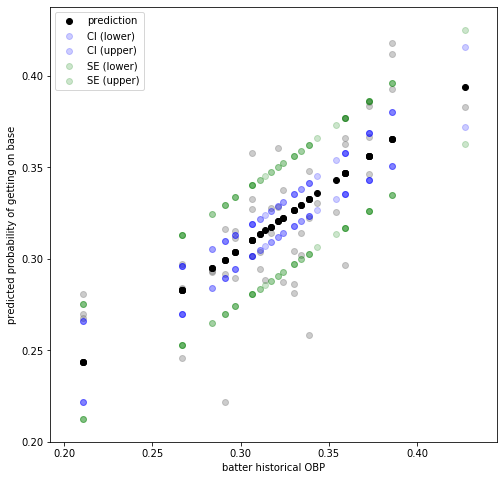

<IPython.core.display.Javascript object>

In [540]:
f, ax1 = plt.subplots(figsize=(8, 8))
ax1.scatter(df_temp["batter_cat"], df_temp["event_mean"], c="gray", alpha=0.4)

ax1.scatter(df_temp["batter_cat"], df_temp.iloc[:, 2], c="black", label="prediction")
ax1.scatter(
    df_temp["batter_cat"], df_temp.iloc[:, 3], c="blue", alpha=0.2, label="CI (lower)",
)
ax1.scatter(
    df_temp["batter_cat"], df_temp.iloc[:, 4], c="blue", alpha=0.2, label="CI (upper)",
)

ax1.scatter(
    df_temp["batter_cat"],
    df_temp["calc_lower_bound"],
    c="green",
    alpha=0.2,
    label="SE (lower)",
)
ax1.scatter(
    df_temp["batter_cat"],
    df_temp["calc_upper_bound"],
    c="green",
    alpha=0.2,
    label="SE (upper)",
)

ax1.set_xlabel("batter historical OBP")
ax1.set_ylabel("predicted probability of getting on base")
ax1.legend()

## Calculating prediction uncertainty - two features

In [569]:
def get_split_data_wscale(X, y, testsize):

    if len(X.shape) > 1:
        # Split data between train and test_and_holdout
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=testsize, random_state=19
        )

    else:
        # Split data between train and test_and_holdout
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=testsize, random_state=19
        )
        print("use brackets")

    # Scale features based on training data
    scaler = StandardScaler().fit(X_train)
    X_train_scale = scaler.transform(X_train)

    # Apply transformation to test data
    X_test_scale = scaler.transform(X_test)

    return X_train_scale, X_test_scale, y_train, y_test, scaler

<IPython.core.display.Javascript object>

In [570]:
(
    X_train_wscale_2f,
    X_test_wscale_2f,
    y_train_wscale_2f,
    y_test_wscale_2f,
    scaler_2f,
) = get_split_data_wscale(
    df_sc_events4model_bp_agg_4model[["batter_cat", "pitcher_cat"]],
    df_sc_events4model_bp_agg_4model["event_mean"],
    0.4,
)

<IPython.core.display.Javascript object>

In [571]:
def run_linreg_model_2var(X_train_scale_set, y_train_set, X_test_scale_set, y_test_set):
    lin_reg = LinearRegression()
    lin_reg.fit(X_train_scale_set, y_train_set)
    y_pred = lin_reg.predict(X_test_scale_set)
    df_eval = pd.DataFrame({"test": y_test_set, "pred": y_pred})

    return lin_reg, df_eval

<IPython.core.display.Javascript object>

In [572]:
lin_reg_wscale_2f, df_eval_wscale_2f = run_linreg_model_2var(
    X_train_wscale_2f, y_train_wscale_2f, X_test_wscale_2f, y_test_wscale_2f
)

<IPython.core.display.Javascript object>

In [562]:
df_eval_wscale_2f.head()

,test,pred
574,0.337190,0.381983
601,0.363770,0.345416
104,0.244851,0.285871
278,0.312102,0.299082
261,0.309453,0.313288


<IPython.core.display.Javascript object>

In [573]:
metrics.r2_score(df_eval_v0["test"], df_eval_v0["pred"])

0.6151561338489827

<IPython.core.display.Javascript object>

In [649]:
batter_name = "Jose Ramirez"


<IPython.core.display.Javascript object>

## Table to generate matchup results

In [1387]:
df_batting_100pa["PA"].min()

101.0

<IPython.core.display.Javascript object>

In [1393]:
df_pitching_50ip["IP"].min()

50.1

<IPython.core.display.Javascript object>

In [691]:
def return_matchup_results_wunc(linreg_model, scaler, batter_name, pitcher_name):
    try:
#         print(
#             "Batter: ", batter_name, "Pitcher: ", pitcher_name,
#         )
        df_batting_stats_wpid_bn = df_batting_stats_wpid.loc[
            df_batting_stats_wpid["Name"] == batter_name
        ].copy()
        # If there's more than one entry, get the latest
        if len(df_batting_stats_wpid_bn) > 1:
            df_batting_stats_wpid_bn = df_batting_stats_wpid_bn.iloc[-1, :]

        batter_obp = np.float(df_batting_stats_wpid_bn["OBP"])

        df_pitching_stats_wpid_pn = df_pitching_stats_wpid.loc[
            df_pitching_stats_wpid["Name"] == pitcher_name
        ].copy()
        # If there's more than one entry, get the latest
        if len(df_pitching_stats_wpid_pn) > 1:
            df_pitching_stats_wpid_pn = df_pitching_stats_wpid_pn.iloc[-1, :]

        pitcher_whip = np.float(
            df_pitching_stats_wpid_pn["WHIP"]
        )
        
    except:
        statement2return = "Juuust, a bit outside. Let's try to get the next one in the zone!"
        print('Something went wrong')

    try:
#         print(
#             "Batter: ", batter_name, batter_obp, "Pitcher: ", pitcher_name, pitcher_whip
#         )
        # Note list within list for numpy and scaler recognizance
        bp_test_vals = [[batter_obp, pitcher_whip]]
        bp_vals_scaled = scaler.transform(np.array(bp_test_vals))

        # Scipy stats linear model

        bp_pred = linreg_model.predict(bp_vals_scaled)
        bp_stdev_y = np.sqrt(
            sum((linreg_model.predict(X_train_scale_d) - y_train_d) ** 2)
            / (len(y_train_d) - 2)
        )

        statement2return = (
            str(np.around(bp_pred[0], 4)) + " +/- " + str(np.around(bp_stdev_y, 3))
        )

    except:
        statement2return = "Yikes, swing-and-a-miss. Let's try to make contact this time."
        print('Something went wrong')

    return statement2return


<IPython.core.display.Javascript object>

In [1399]:
batter_list = df_batting_100pa["Name"]
pitcher_list = df_pitching_50ip["Name"]

<IPython.core.display.Javascript object>

In [1395]:
len(df_batting_100pa["Name"].unique())

429

<IPython.core.display.Javascript object>

In [1396]:
len(df_pitching_50ip["Name"].unique())

335

<IPython.core.display.Javascript object>

In [1400]:
batter_whole_list = list()
pitcher_whole_list = list()
results_whole_list = list()

for this_batter in batter_list:
    for this_pitcher in pitcher_list:
        try:
            results_whole_list.append(
                return_matchup_results_wunc(
                    lin_reg_wscale_2f, scaler_2f, this_batter, this_pitcher
                )
            )
            batter_whole_list.append(this_batter)
            pitcher_whole_list.append(this_pitcher)

        except:
            continue

df2save = pd.DataFrame(
    {
        "Batter": batter_whole_list,
        "Pitcher": pitcher_whole_list,
        "Results": results_whole_list,
    }
)

df2save.to_csv("flask_insight_notes/flask_baseball/bp_output_results.csv")

<IPython.core.display.Javascript object>

In [1401]:
df2save.shape

(145152, 3)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>